# ECE 232E Project 1 - Random Graphs and Random Walks
By Anthony Lei, Swetha Pillai, and Morgan Worthington

In [2]:
install.packages("igraph")
install.packages("pracma")

library('igraph')
library('Matrix')
library('pracma')

install.packages('matrixStats')
library(matrixStats)


The downloaded binary packages are in
	/var/folders/nt/t764cvhn2l95gxbxxlzq8ksh0000gn/T//Rtmpm8Krsc/downloaded_packages

The downloaded binary packages are in
	/var/folders/nt/t764cvhn2l95gxbxxlzq8ksh0000gn/T//Rtmpm8Krsc/downloaded_packages



Attaching package: 'igraph'


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union



Attaching package: 'pracma'


The following objects are masked from 'package:Matrix':

    expm, lu, tril, triu





The downloaded binary packages are in
	/var/folders/nt/t764cvhn2l95gxbxxlzq8ksh0000gn/T//Rtmpm8Krsc/downloaded_packages


# 1. Generating Random Networks

first third - Anthony

second third - Swetha

3. Create a modified preferential attachment model that penalizes the age of a node

(a) Produce such an undirected network with 1000 nodes and parameters m = 1,
α = 1, β = −1, and a = c = d = 1, b = 0. Plot the degree distribution. What is the
power law exponent?

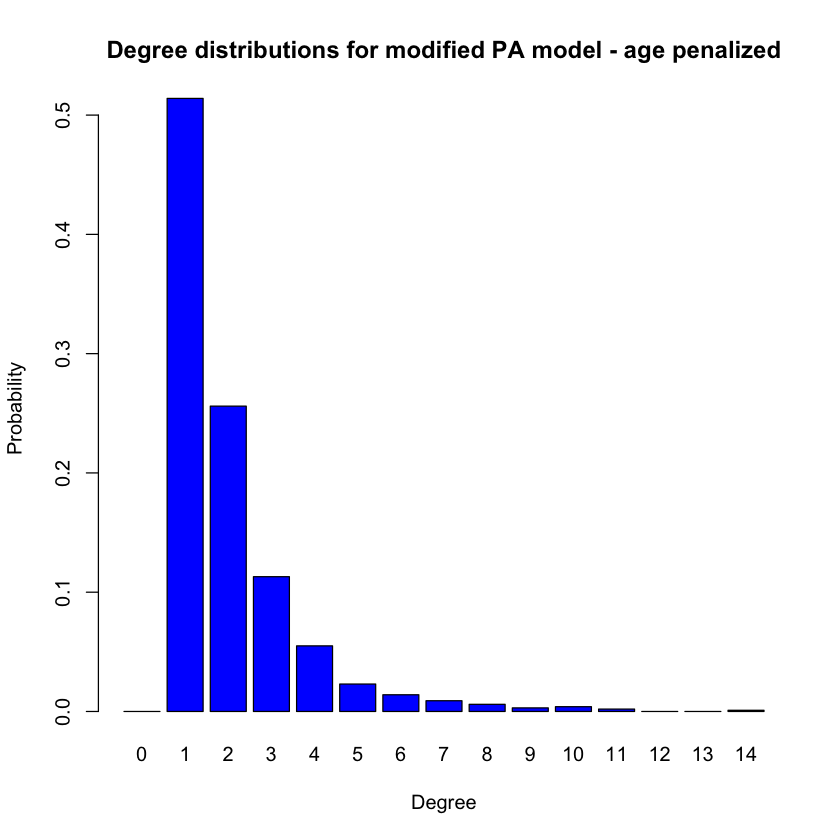

In [3]:
pa_age <- sample_pa_age(1000, m=1, pa.exp=1, aging.exp=-1, zero.deg.appeal=1, zero.age.appeal=0, deg.coef=1, age.coef=1, directed=FALSE)

# Plotting the node degree distribution as a bar plot
node_deg_dist = degree.distribution(pa_age)
xVals = c(0: (length(node_deg_dist) - 1))
barplot(node_deg_dist, names.arg=xVals, xlab="Degree", ylab="Probability",
        main = paste("Degree distributions for modified PA model - age penalized", sep = " "),col="blue")


Call:
lm(formula = log10(probability) ~ log10(degree))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.33734 -0.13183  0.04749  0.08599  0.20948 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)     0.0483     0.1238    0.39    0.705    
log10(degree)  -2.5204     0.1554  -16.22 1.65e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1729 on 10 degrees of freedom
Multiple R-squared:  0.9634,	Adjusted R-squared:  0.9597 
F-statistic:   263 on 1 and 10 DF,  p-value: 1.648e-08


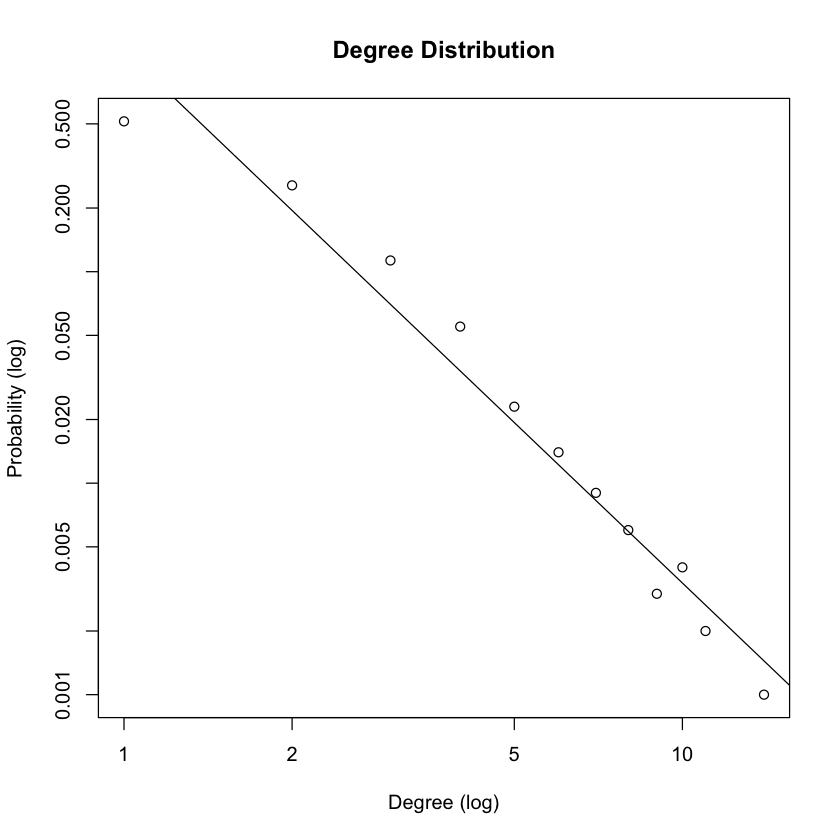

In [4]:
plot_degree_distribution = function(graph) {
  # calculate degree
  d = degree(graph, mode = "all")
  dd = degree.distribution(graph, mode = "all", cumulative = FALSE)
  degree = 1:max(d)
  probability = dd[-1]
  # delete blank values
  nonzero.position = which(probability != 0)
  probability = probability[nonzero.position]
  degree = degree[nonzero.position]
  # plot
  plot(probability ~ degree, log = "xy", xlab = "Degree (log)", ylab = "Probability (log)", 
       col = 1, main = "Degree Distribution")
  abline(lm(log10(probability) ~ log10(degree)))
  summary(lm(log10(probability) ~ log10(degree)))
}

plot_degree_distribution(pa_age)

From the lectures, the power-law exponent corresponds to the slope of the linear regression on the log-log plot. Here, it is approximately -2.5.

(b) Use fast greedy method to find the community structure. What is the modularity?

In [5]:
modularity(cluster_fast_greedy(pa_age))

[1] 0.9358698

# 2. Random Walk on Networks

### 1. Random walk on Erdos-Renyi networks

(a) Create an undirected random network with 1000 nodes, and the probability p for drawing an edge between any pair of nodes equal to 0.01.

In [9]:
num_nodes = 1000
edge_prob = 0.01
g_1000 = sample_gnp(num_nodes, edge_prob, directed = FALSE)

(b) Let a random walker start from a randomly selected node (no teleportation). We use t to denote the number of steps that the walker has taken. Measure the average distance (defined as the shortest path length) ⟨s(t)⟩ of the walker from his starting point at step t. Also, measure the variance $σ^2(t) = ⟨(s(t) − ⟨s(t)⟩)^2⟩$ of this distance. Plot ⟨s(t)⟩ v.s. t and $σ^2(t)$ v.s. t. Here, the average ⟨·⟩ is over random choices of the starting nodes.

In [7]:
t = 100
ver_sequence = c(1:t)

# Helper function provided for random walk
create_transition_matrix = function (g){
    
    # WARNING: make sure your graph is connected (you might input GCC of your graph)
    
    vs = V(g)
    n = vcount(g)
    adj = as_adjacency_matrix(g)
    adj[diag(rowSums(adj) == 0)] = 1  # handle if the user is using the function for networks with isolated nodes by creating self-edges
    z = matrix(rowSums(adj, , 1))
    
    transition_matrix = adj / repmat(z, 1, n)  # normalize to get probabilities
    
    return(transition_matrix)
}


random_walk = function (g, num_steps, start_node, transition_matrix = NULL){
    if(is.null(transition_matrix))
        transition_matrix = create_transition_matrix(g)
        
    v = start_node
    for(i in 1:num_steps){
    
        # fprintf('Step %d: %d\n', i, v)  # COMMENT THIS
        ver_sequence[i] = v
        PMF = transition_matrix[v, ]
        # perform random walk
        v = sample(1:vcount(g), 1, prob = PMF)
        if(i == t)
          # dis = distances(g,v= start_node, to=v)
          # dis = shortest.paths(g,)
          degree_ = degree(g,v)
    }
   return(list(distances = ver_sequence,degrees = degree_))
}

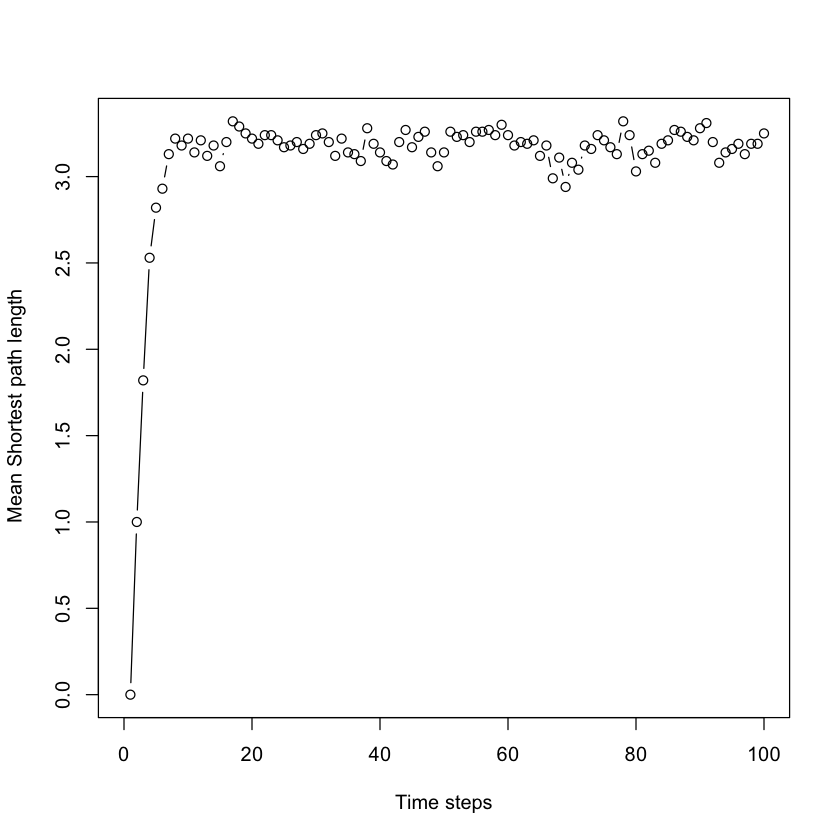

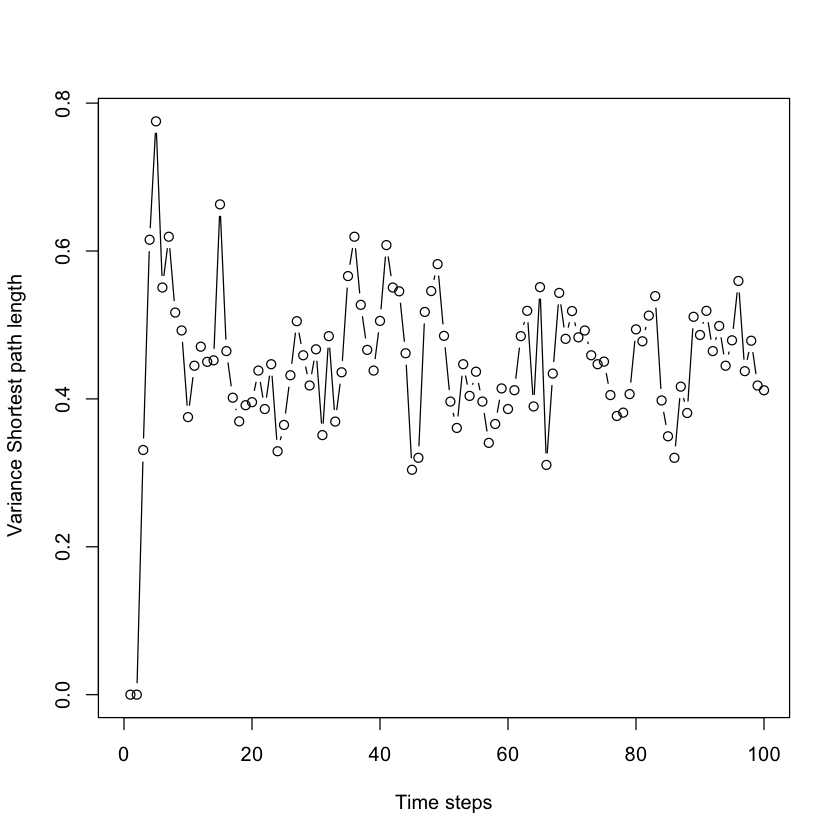

In [10]:
# Performing a 100 step random walk for 100 times on the erdos graph and plotting the mean and
# the variance of the shortest path
degree_list = c(1:100)
iters = 100
distances = matrix(NA, nrow=iters, ncol=t)
start_nodes = sample(1:vcount(g_1000),100)
for(i in 1:iters){
    results = random_walk(g_1000,t,start_nodes[i])
    vertex_sequences = results[['distances']]
    end_node_degree = results[['degrees']][1]
    distances[i,] = shortest.paths(g_1000,vertex_sequences,start_nodes[i])
    degree_list[i] = end_node_degree
}

plot(colMeans(distances),type="b", xlab='Time steps', ylab=' Mean Shortest path length', xlim=c(0,100))
plot(colVars(distances),type="b", xlab='Time steps', ylab=' Variance Shortest path length', xlim=c(0,100))

(c) Measure the degree distribution of the nodes reached at the end of the random walk. How does it compare to the degree distribution of the graph?

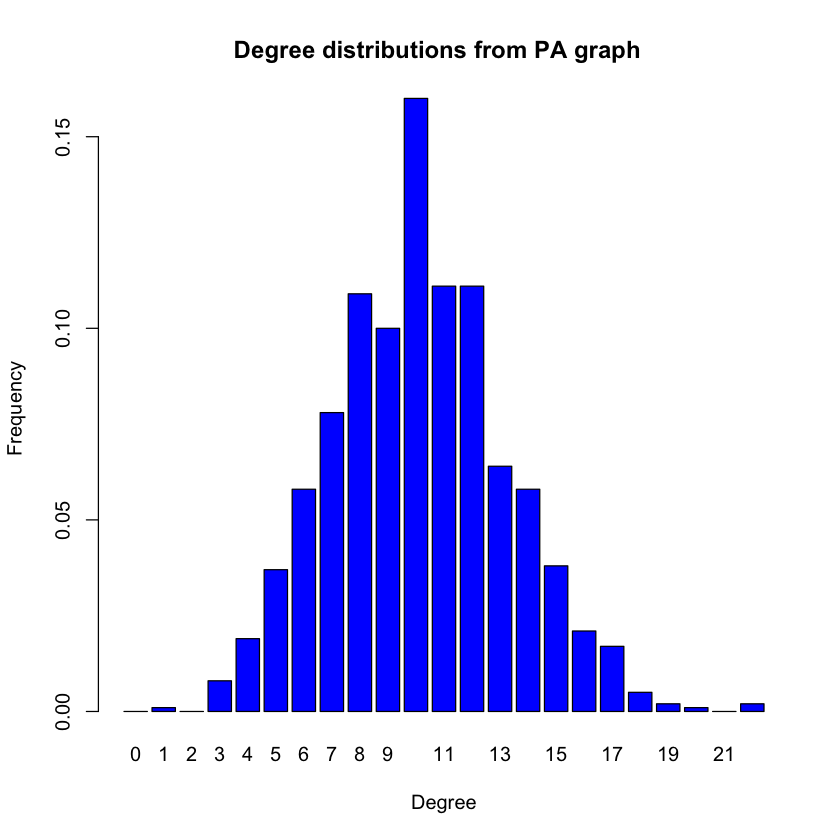

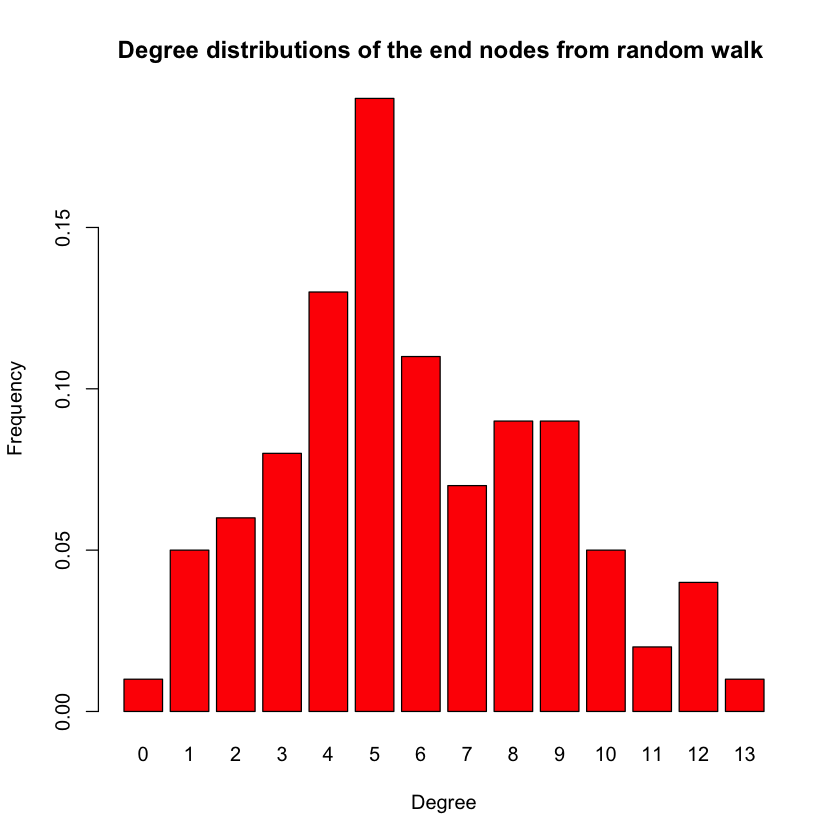

In [12]:
#  degree distribution of graph
d_dist = degree.distribution(g_1000)
xVals = c(0: (length(d_dist) - 1))
barplot(d_dist, names.arg=xVals, xlab="Degree", ylab="Frequency",
            main = paste("Degree distributions from PA graph  " ,sep = " "), col="blue")


#  degree distribution from random walk over random nodes
freq = table(degree_list)/length(degree_list)
xVals = c(0: (length(freq) - 1))
barplot(freq, names.arg=xVals, xlab="Degree", ylab="Frequency",
            main = paste("Degree distributions of the end nodes from random walk " ,sep = " "), col="red")

They look roughly comparable in shape. The peak for the overall degree distribution is greater than the peak for the random walk distribution. Both peaks are at different degrees. The right tail is also larger for the overall distribution compared to the random walk distribution.

(d) Repeat 1(b) for undirected random networks with 10000 nodes. Compare the results and explain qualitatively. Does the diameter of the network play a role?

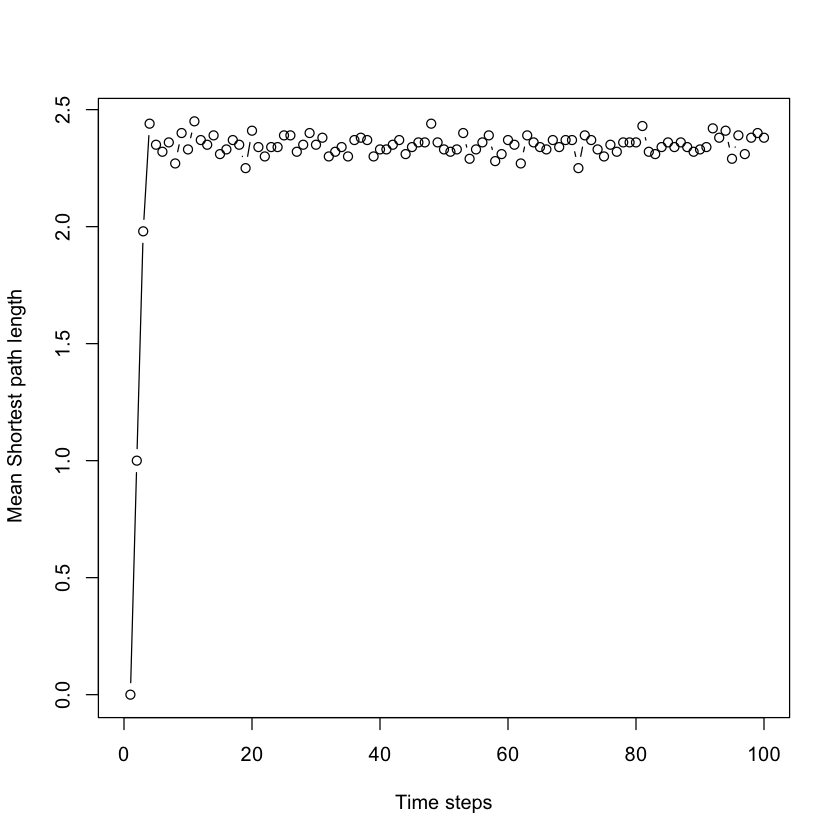

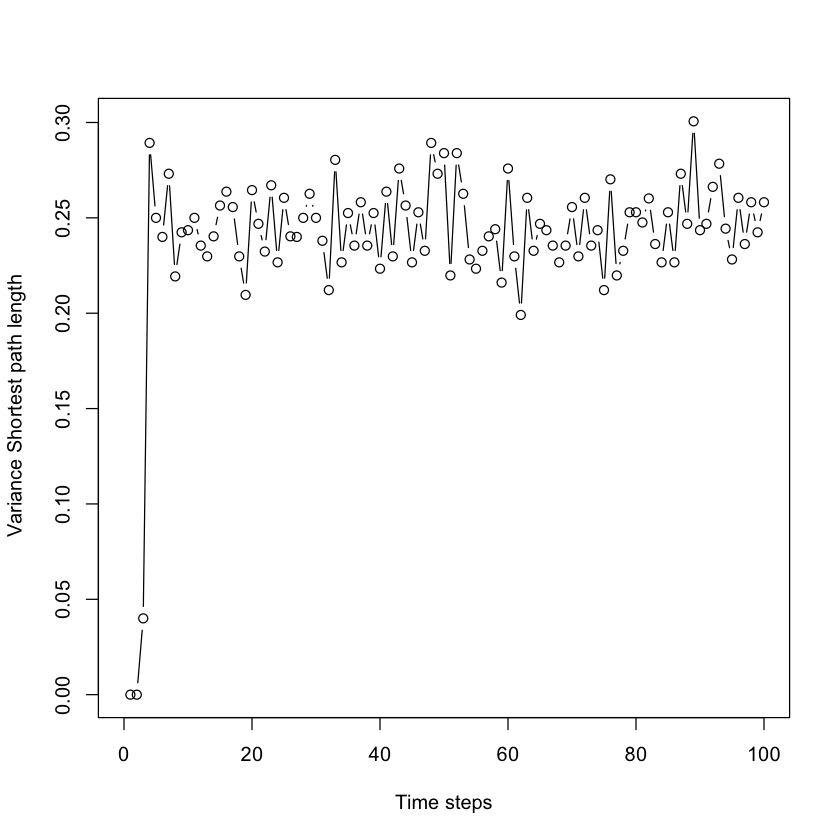

In [13]:
num_nodes = 10000
edge_prob = 0.01
g_10000 = sample_gnp(num_nodes, edge_prob, directed = FALSE)

degree_list = c(1:100)
iters = 100
distances = matrix(NA, nrow=iters, ncol=t)
start_nodes = sample(1:vcount(g_10000),100)
for(i in 1:iters){
    results = random_walk(g_10000,t,start_nodes[i])
    vertex_sequences = results[['distances']]
    end_node_degree = results[['degrees']][1]
    distances[i,] = shortest.paths(g_10000,vertex_sequences,start_nodes[i])
    degree_list[i] = end_node_degree
}

plot(colMeans(distances),type="b", xlab='Time steps', ylab=' Mean Shortest path length', xlim=c(0,100))
plot(colVars(distances),type="b", xlab='Time steps', ylab=' Variance Shortest path length', xlim=c(0,100))

In [14]:
print(paste("Diameter when n = 1000:", diameter(g_1000)))
print(paste("Diameter when n = 10000:", diameter(g_10000)))

[1] "Diameter when n = 1000: 6"
[1] "Diameter when n = 10000: 3"


Both the maximum mean shortest path and maximum variance shortest path are slightly lower for n=10000 at around 2.5 and 0.3 respectively than for n=1000 at 3.5 and 0.8 respectively. For n=1000, the mean looks to converge around 3.25 and the variance looks to converge around 0.45. For n=10000, the mean looks to converge around 2.4 and the variance looks to converge around 0.25. It appears that the diameter of the network does play a role since the network with the shorter diameter has a lower mean shortest path and lower variance.

## 2. Random walk on networks with fat-tailed degree distribution

(a) Generate an undirected preferential attachment network with 1000 nodes, where each new node attaches to m = 1 old nodes.

In [17]:
pa_1000 = sample_pa(n=1000, m=1, directed = FALSE)

(b) Let a random walker start from a randomly selected node. Measure and plot ⟨s(t)⟩ v.s. t and $σ^2(t)$ v.s. t.

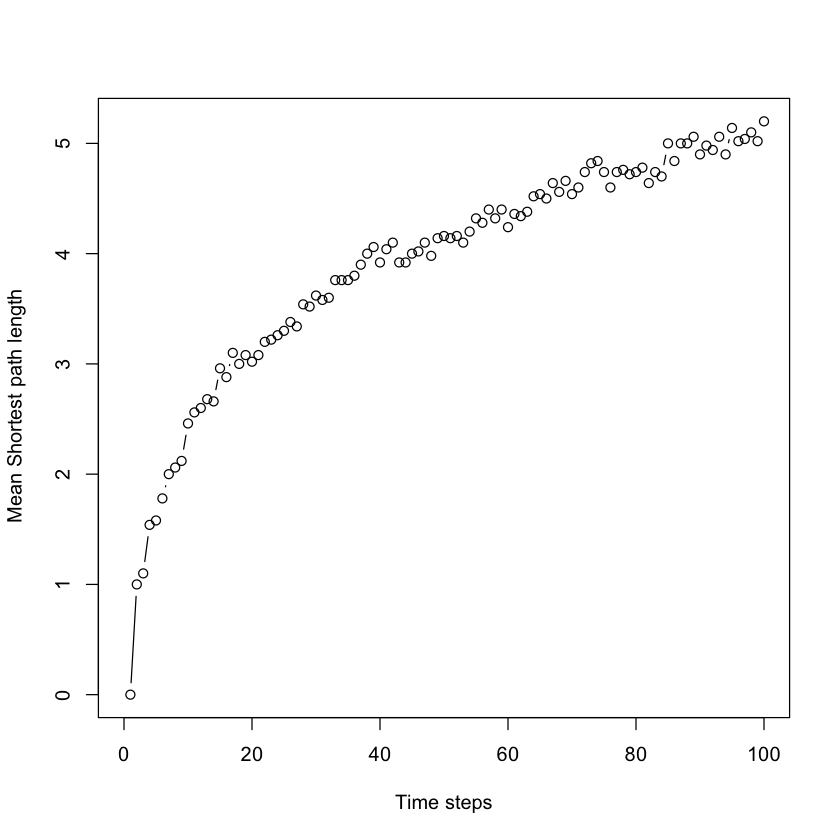

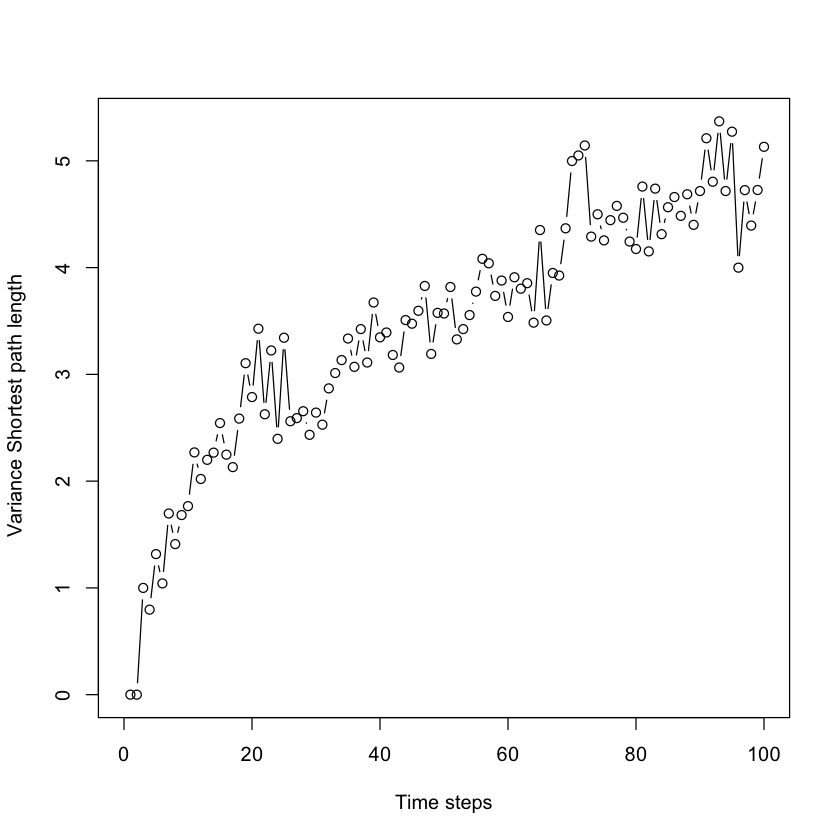

In [18]:
degree_list = c(1:100)
iters = 100
distances = matrix(NA, nrow=iters, ncol=t)
start_nodes = sample(1:vcount(pa_1000),100)
for(i in 1:iters){
    results = random_walk(pa_1000,t,start_nodes[i])
    vertex_sequences = results[['distances']]
    end_node_degree = results[['degrees']][1]
    distances[i,] = shortest.paths(pa_1000,vertex_sequences,start_nodes[i])
    degree_list[i] = end_node_degree
}

plot(colMeans(distances),type="b", xlab='Time steps', ylab=' Mean Shortest path length', xlim=c(0,100))
plot(colVars(distances),type="b", xlab='Time steps', ylab=' Variance Shortest path length', xlim=c(0,100))

(c) Measure the degree distribution of the nodes reached at the end of the random walk on this network. How does it compare with the degree distribution of the graph?

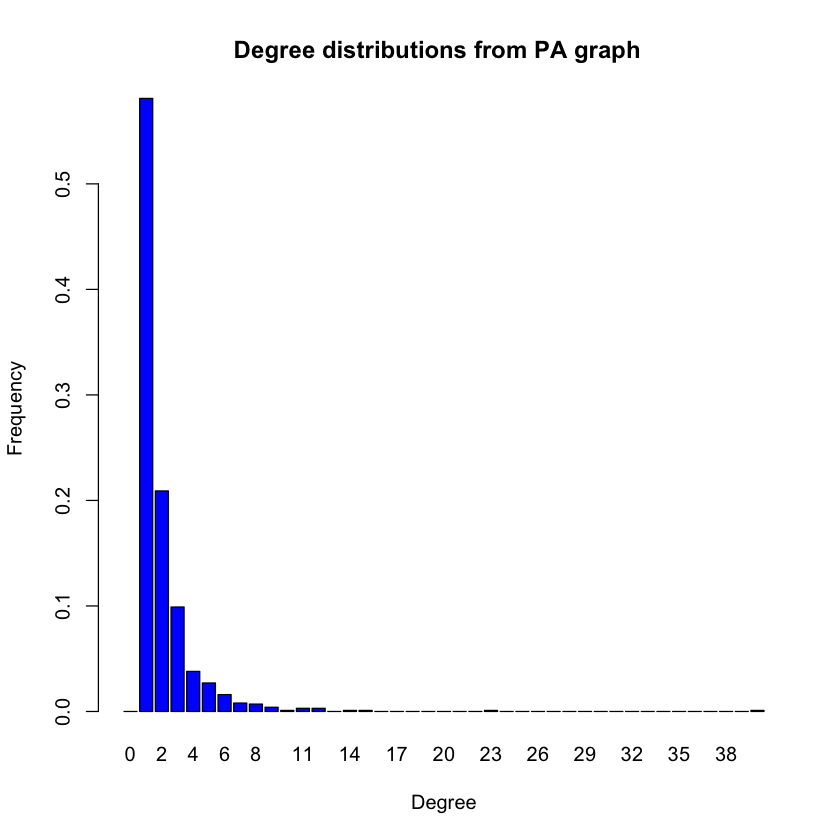

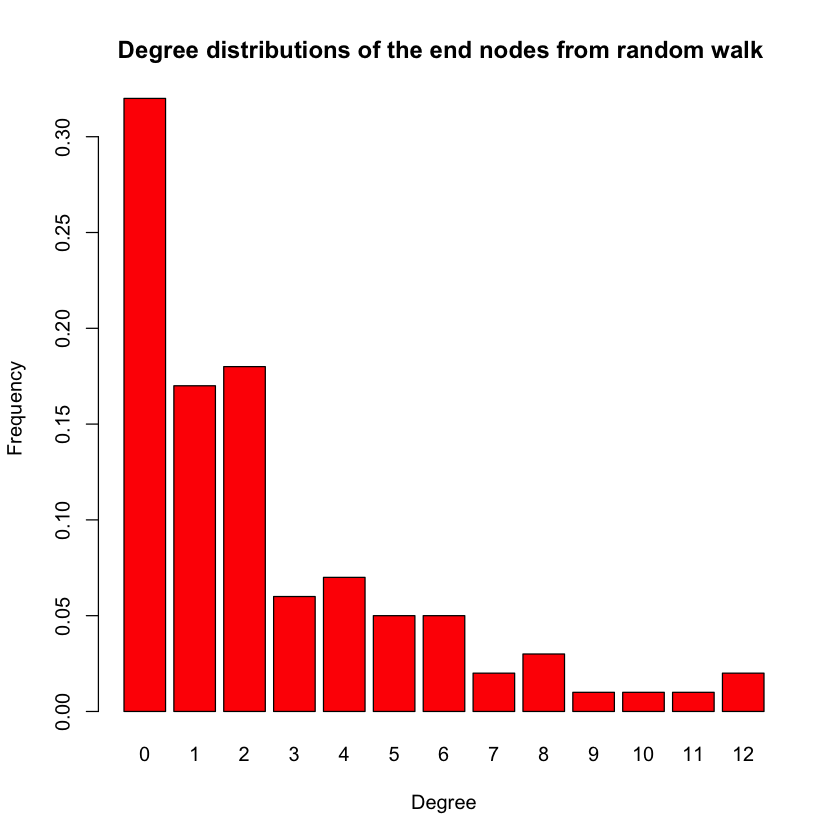

In [19]:
#  degree distribution of graph
d_dist = degree.distribution(pa_1000)
xVals = c(0: (length(d_dist) - 1))
barplot(d_dist, names.arg=xVals, xlab="Degree", ylab="Frequency",
            main = paste("Degree distributions from PA graph  " ,sep = " "), col="blue")


#  degree distribution from random walk over random nodes
freq = table(degree_list)/length(degree_list)
xVals = c(0: (length(freq) - 1))
barplot(freq, names.arg=xVals, xlab="Degree", ylab="Frequency",
            main = paste("Degree distributions of the end nodes from random walk " ,sep = " "), col="red")

Both distributions are fat-tailed with degree 0 having the largest frequency. The overall distribution has a much larger frequency for this degree. There are fluctuations on the right-hand tail of the random walk distribution that are not present in the overall distribution.

(d) Repeat 2(b) for preferential attachment networks with 100 and 10000 nodes, and m = 1. Compare the results and explain qualitatively. Does the diameter of the network play a role?

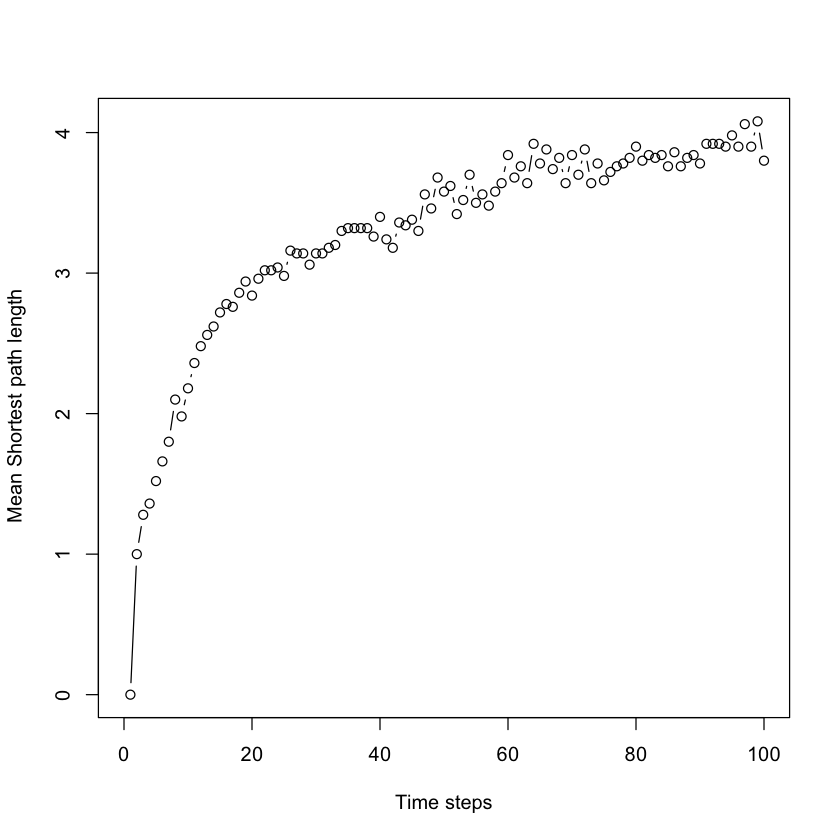

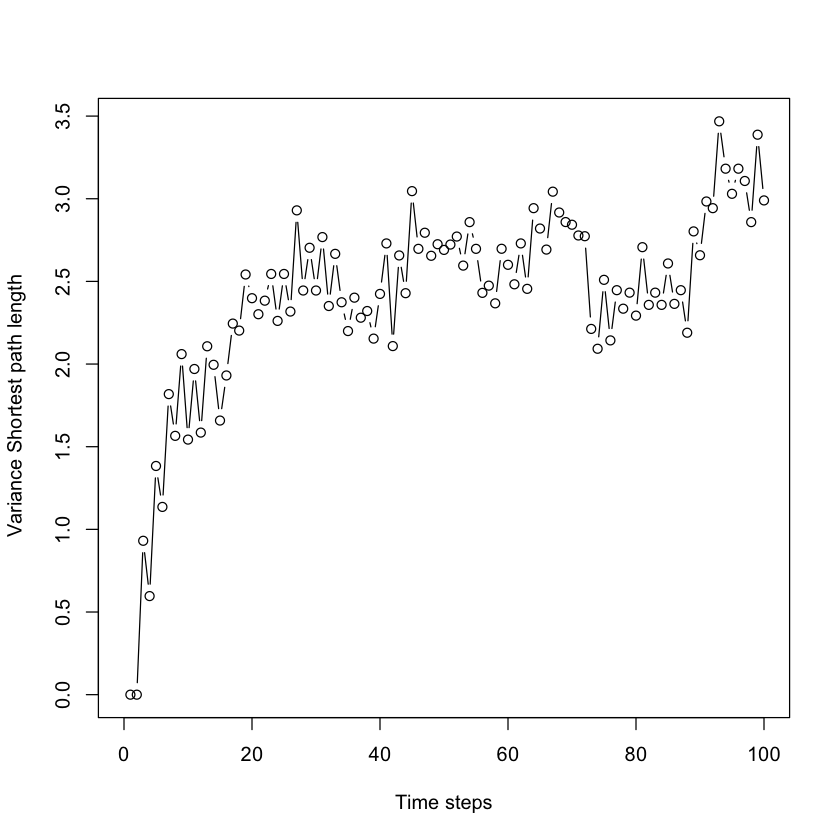

In [20]:
pa_100 = sample_pa(n=100, m=1, directed = FALSE)

degree_list = c(1:100)
iters = 100
distances = matrix(NA, nrow=iters, ncol=t)
start_nodes = sample(1:vcount(pa_100),100)
for(i in 1:iters){
    results = random_walk(pa_100,t,start_nodes[i])
    vertex_sequences = results[['distances']]
    end_node_degree = results[['degrees']][1]
    distances[i,] = shortest.paths(pa_100,vertex_sequences,start_nodes[i])
    degree_list[i] = end_node_degree
}

plot(colMeans(distances),type="b", xlab='Time steps', ylab=' Mean Shortest path length', xlim=c(0,100))
plot(colVars(distances),type="b", xlab='Time steps', ylab=' Variance Shortest path length', xlim=c(0,100))

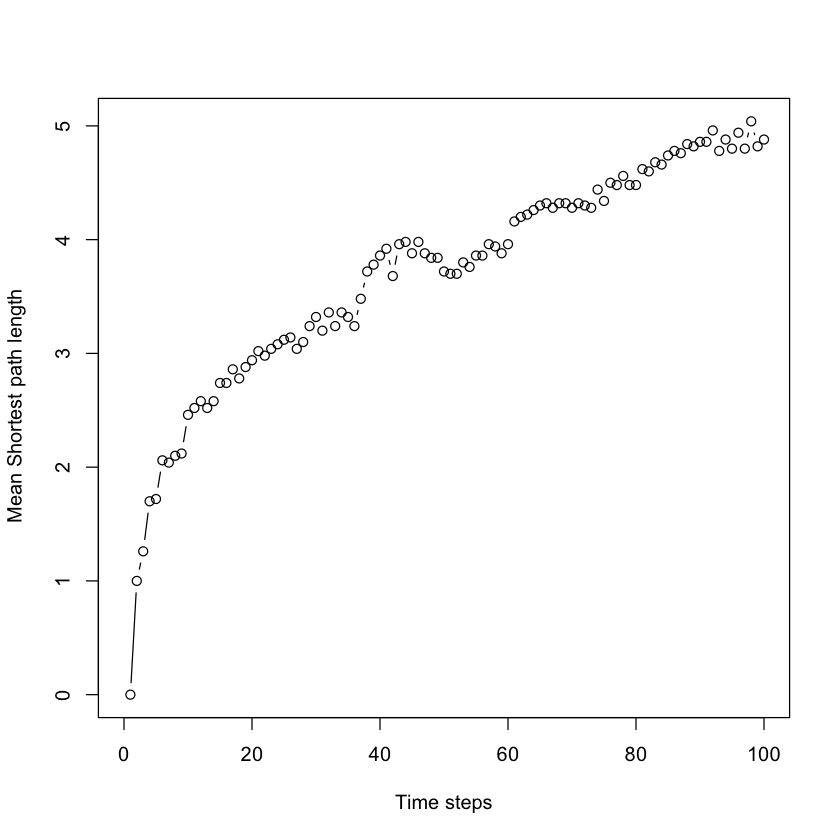

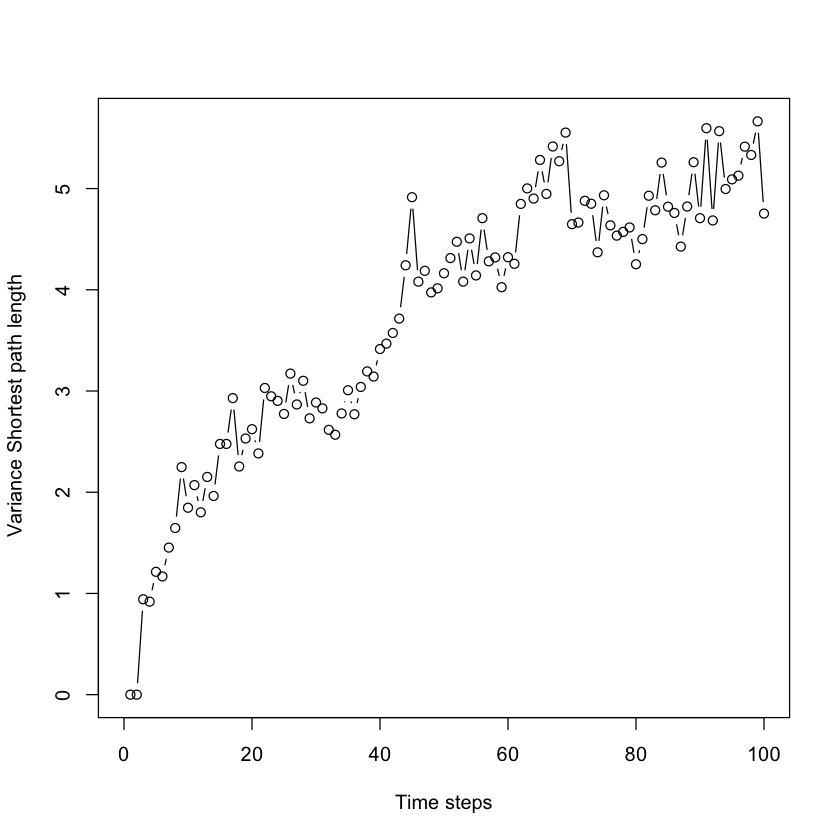

In [21]:
pa_10000 = sample_pa(n=10000, m=1, directed = FALSE)

degree_list = c(1:100)
iters = 100
distances = matrix(NA, nrow=iters, ncol=t)
start_nodes = sample(1:vcount(pa_10000),100)
for(i in 1:iters){
    results = random_walk(pa_10000,t,start_nodes[i])
    vertex_sequences = results[['distances']]
    end_node_degree = results[['degrees']][1]
    distances[i,] = shortest.paths(pa_10000,vertex_sequences,start_nodes[i])
    degree_list[i] = end_node_degree
}

plot(colMeans(distances),type="b", xlab='Time steps', ylab=' Mean Shortest path length', xlim=c(0,100))
plot(colVars(distances),type="b", xlab='Time steps', ylab=' Variance Shortest path length', xlim=c(0,100))

In [23]:
print(paste("Diameter when n = 100:", diameter(pa_100)))
print(paste("Diameter when n = 1000:", diameter(pa_1000)))
print(paste("Diameter when n = 10000:", diameter(pa_10000)))

[1] "Diameter when n = 100: 11"
[1] "Diameter when n = 1000: 21"
[1] "Diameter when n = 10000: 25"


For n=1000, both the mean and variance approach 5. For n=100, the mean approaches 4 while the variance is slightly more erratic as it approaches 3.5. For n=10000, the mean approaches 5 while the variance approaches 6. It appears that the diameter of the network does play a subtle role since for a smaller number of nodes, both the mean and variance are lower than those for larger number of nodes. However, there does seem to be a threshold where the maximum values converge to.

last third - Morgan

# 2. Random Walk on Networks

1. Random walk on Erd ̈os-R ́enyi networks

(a) Create an undirected random network with 1000 nodes, and the probability p for
drawing an edge between any pair of nodes equal to 0.01

In [598]:
num_nodes = 1000
edge_prob=0.01
g = sample_gnp(num_nodes, edge_prob, directed = FALSE)

(b) Let a random walker start from a randomly selected node (no teleportation). We use t to denote the number of steps that the walker has taken. Measure the average distance (defined as the shortest path length) ⟨s(t)⟩ of the walker from his starting point at step t. Also, measure the variance $σ^2(t) = ⟨(s(t) − ⟨s(t)⟩)^2⟩$ of this distance. Plot ⟨s(t)⟩ v.s. t and $σ^2(t)$ v.s. t. Here, the average ⟨·⟩ is over random choices of the starting nodes.

In [578]:
t = 100
ver_sequence = c(1:t)

# Helper function provided for random walk
create_transition_matrix = function (g){
    
    # WARNING: make sure your graph is connected (you might input GCC of your graph)
    
    vs = V(g)
    n = vcount(g)
    adj = as_adjacency_matrix(g)
    adj[diag(rowSums(adj) == 0)] = 1  # handle if the user is using the function for networks with isolated nodes by creating self-edges
    z = matrix(rowSums(adj, , 1))
    
    transition_matrix = adj / repmat(z, 1, n)  # normalize to get probabilities
    
    return(transition_matrix)
}


random_walk = function (g, num_steps, start_node, transition_matrix = NULL){
    if(is.null(transition_matrix))
        transition_matrix = create_transition_matrix(g)
        
    v = start_node
    for(i in 1:num_steps){
    
        # fprintf('Step %d: %d\n', i, v)  # COMMENT THIS
        ver_sequence[i] = v
        PMF = transition_matrix[v, ]
        # perform random walk
        v = sample(1:vcount(g), 1, prob = PMF)
        if(i == t)
          # dis = distances(g,v= start_node, to=v)
          # dis = shortest.paths(g,)
          degree_ = degree(g,v)
    }
   return(list(distances = ver_sequence,degrees = degree_))
}

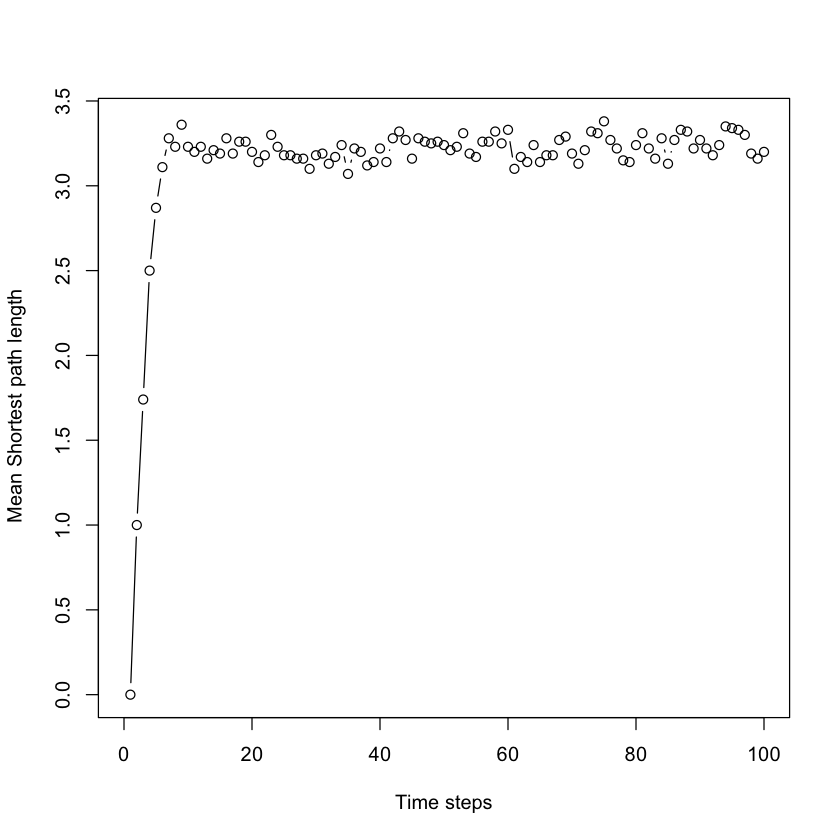

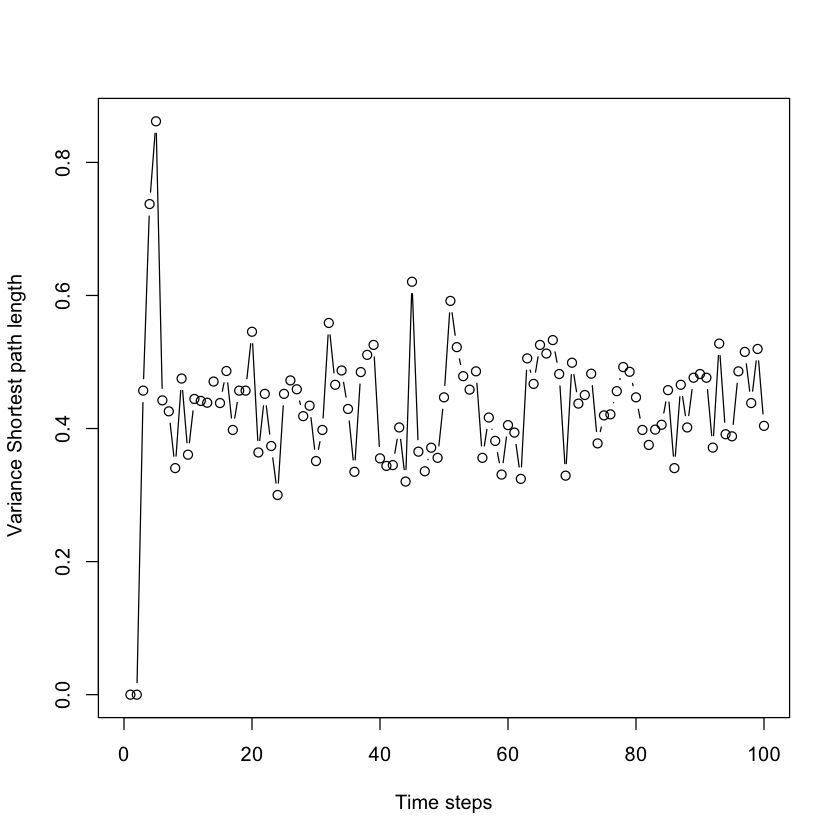

In [510]:
degree_list = c(1:100)
iters = 100
distances = matrix(NA, nrow=iters, ncol=t)
start_nodes = sample(1:vcount(g),100)
for(i in 1:iters){
    results = random_walk(g,t,start_nodes[i])
    vertex_sequences = results[['distances']]
    end_node_degree = results[['degrees']][1]
    distances[i,] = shortest.paths(g,vertex_sequences,start_nodes[i])
    degree_list[i] = end_node_degree
}

plot(colMeans(distances),type="b", xlab='Time steps', ylab=' Mean Shortest path length', xlim=c(0,100))
plot(colVars(distances),type="b", xlab='Time steps', ylab=' Variance Shortest path length', xlim=c(0,100))


(c) Measure the degree distribution of the nodes reached at the end of the random walk.
How does it compare to the degree distribution of graph?

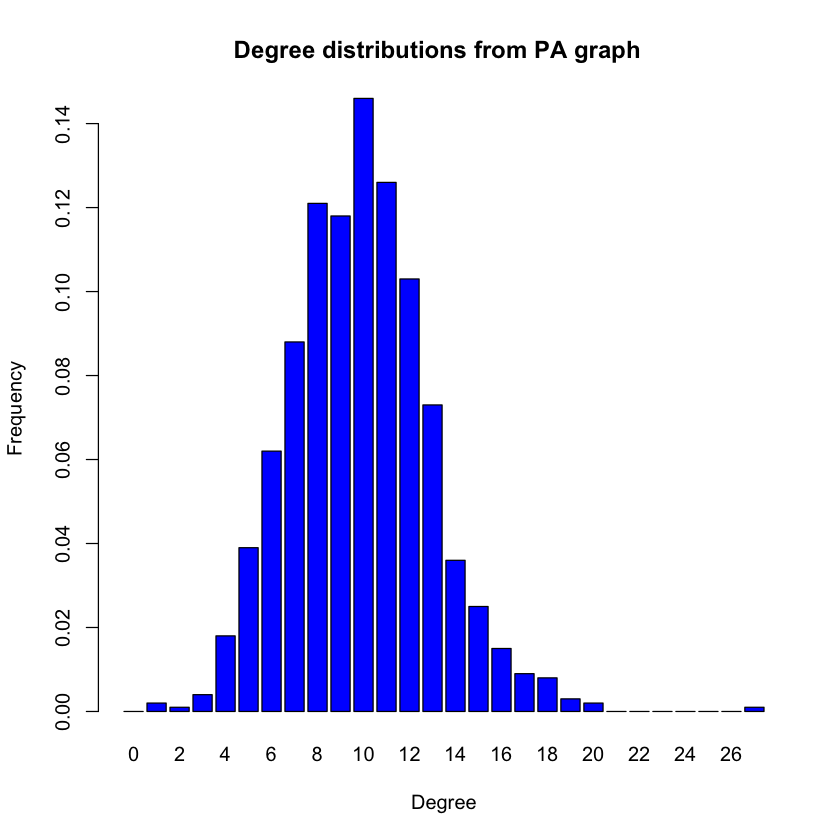

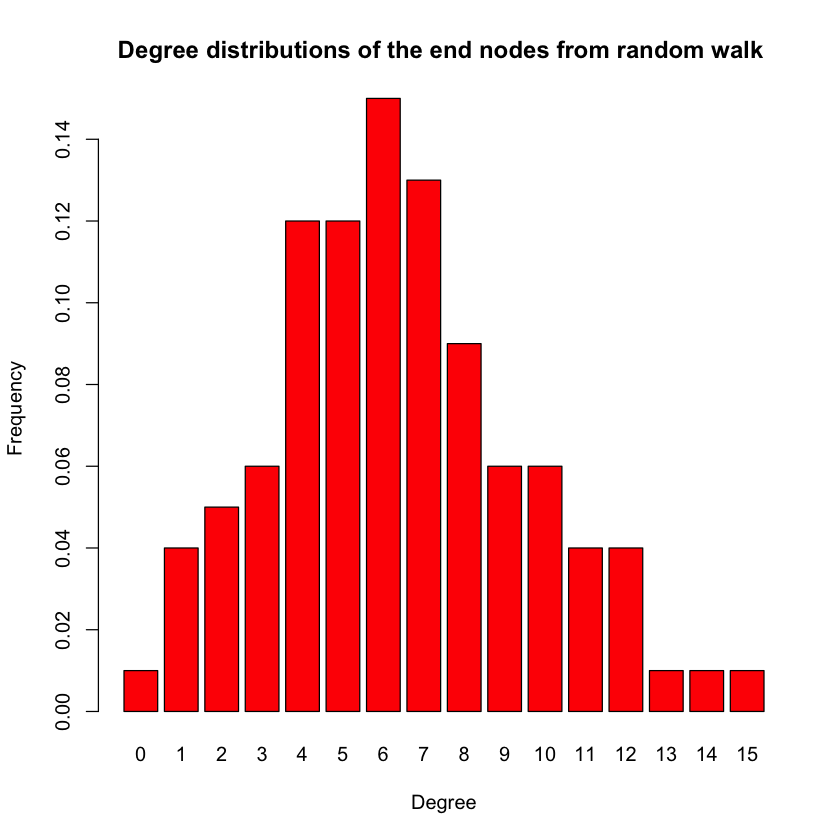

In [509]:
#  degree distribution of graph
d_dist = degree.distribution(g)
xVals = c(0: (length(d_dist) - 1))
barplot(d_dist, names.arg=xVals, xlab="Degree", ylab="Frequency",
            main = paste("Degree distributions from PA graph  " ,sep = " "), col="blue")


#  degree distribution from random walk over random nodes
freq = table(degree_list)/length(degree_list)
xVals = c(0: (length(freq) - 1))
barplot(freq, names.arg=xVals, xlab="Degree", ylab="Frequency",
            main = paste("Degree distributions of the end nodes from random walk " ,sep = " "), col="red")

They look roughly comparable in shape. The peak for the overall degree distribution is greater than the peak for the random walk distribution. The right tail is also larger for the overall distribution compared to the random walk distribution.

(d) Repeat 1(b) for undirected random networks with 10000 nodes. Compare the results
and explain qualitatively. Does the diameter of the network play a role?

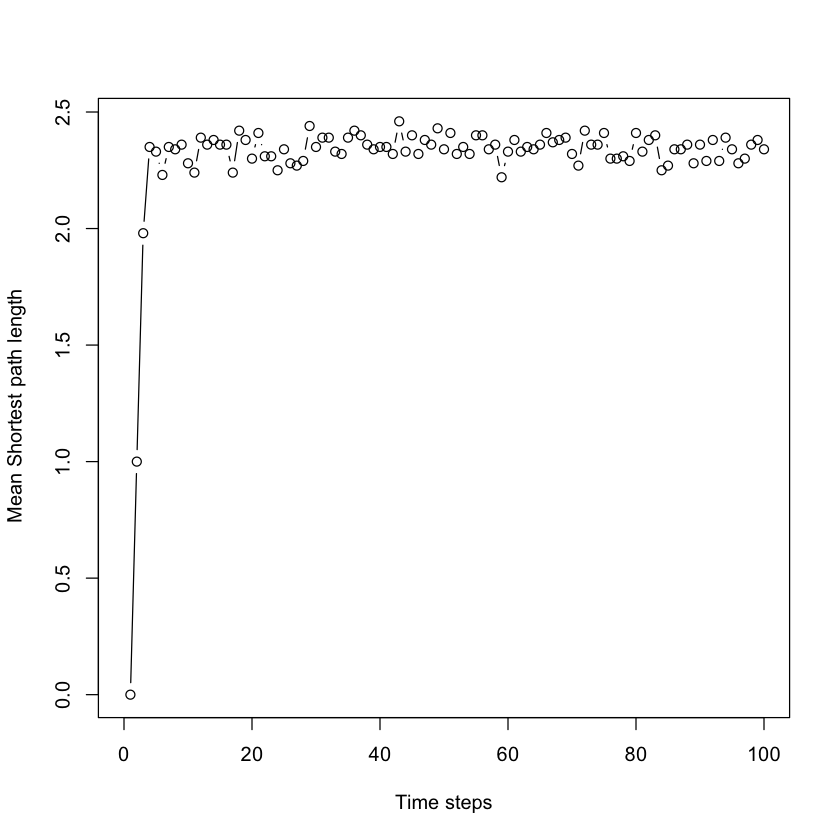

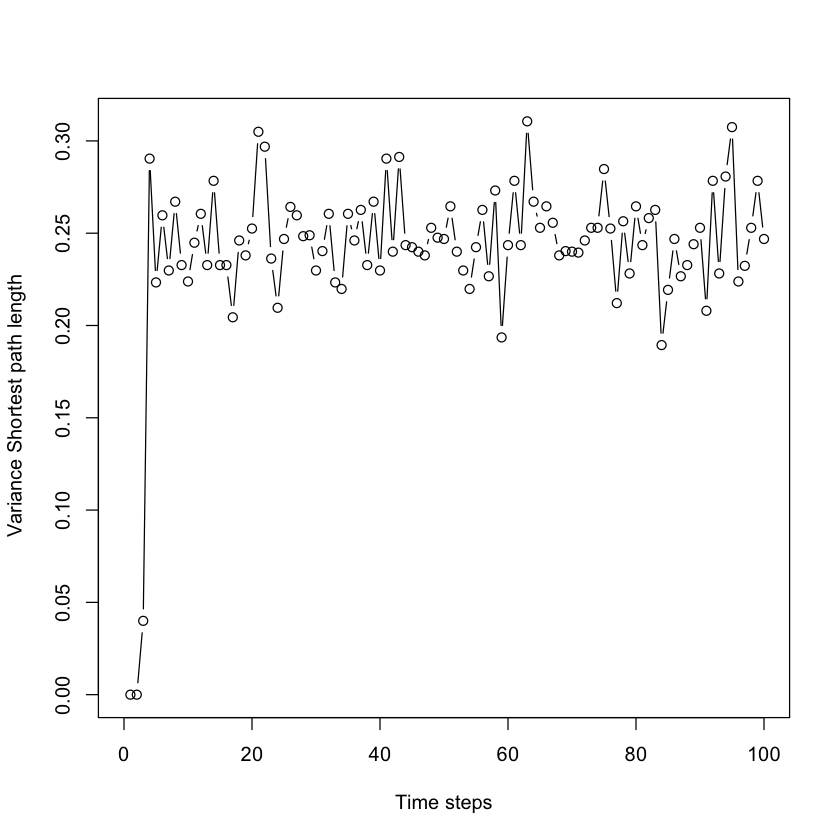

In [599]:
num_nodes = 10000
edge_prob = 0.01
g2 = sample_gnp(num_nodes, edge_prob, directed = FALSE)
degree_list = c(1:100)
iters = 100
distances = matrix(NA, nrow=iters, ncol=t)
start_nodes = sample(1:vcount(g2),100)
for(i in 1:iters){
    results = random_walk(g2,t,start_nodes[i])
    vertex_sequences = results[['distances']]
    end_node_degree = results[['degrees']][1]
    distances[i,] = shortest.paths(g2,vertex_sequences,start_nodes[i])
    degree_list[i] = end_node_degree
}

plot(colMeans(distances),type="b", xlab='Time steps', ylab=' Mean Shortest path length', xlim=c(0,100))
plot(colVars(distances),type="b", xlab='Time steps', ylab=' Variance Shortest path length', xlim=c(0,100))

In [601]:
print(paste("Diameter when n=1000:", diameter(g)))
print(paste("Diameter when n=10000:", diameter(g2)))

[1] "Diameter when n=1000: 5"
[1] "Diameter when n=10000: 3"


Both the maximum mean shortest path and maximum variance shortest path are slightly lower for n=10000 at around 2.5 and 0.3 respectively than for n=1000 at 3.5 and 0.8 respectively. For n=1000, the mean looks to converge around 3.25 and the variance looks to converge around 0.45.  
  
It looks like the diameter being greater for n=1000 corresponds to larger converged values for both mean shortest path length and variance shortest path length compared to the values for n=10000.

2. Random walk on networks with fat-tailed degree distribution

(a) Generate an undirected preferential attachment network with 1000 nodes, where each
new node attaches to m = 1 old nodes.

In [528]:
pa_g = sample_pa(1000,m=1,directed=FALSE)

(b) Let a random walker start from a randomly selected node. Measure and plot ⟨s(t)⟩
v.s. t and $σ^2(t)$ v.s. t.

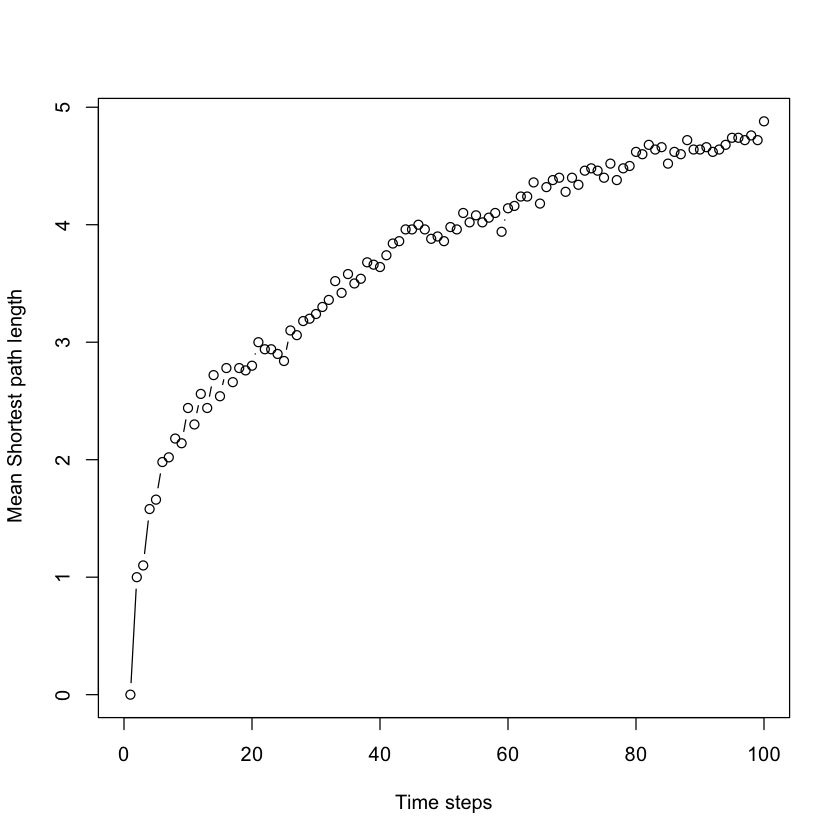

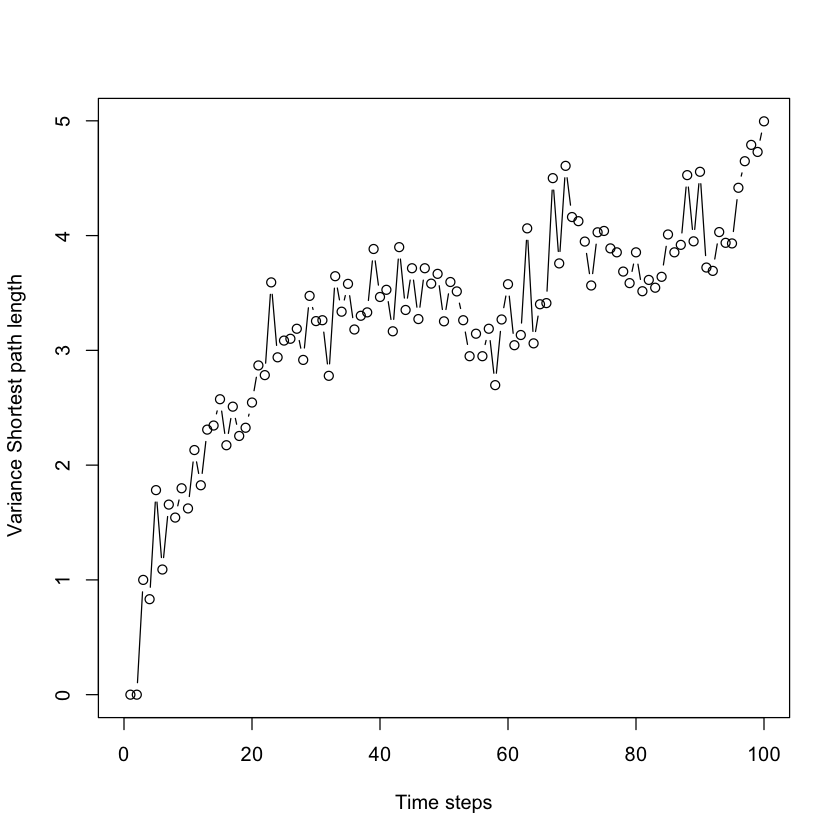

In [529]:
degree_list = c(1:100)
iters = 100
distances = matrix(NA, nrow=iters, ncol=t)
start_nodes = sample(1:vcount(pa_g),100)
for(i in 1:iters){
    results = random_walk(pa_g,t,start_nodes[i])
    vertex_sequences = results[['distances']]
    end_node_degree = results[['degrees']][1]
    distances[i,] = shortest.paths(pa_g,vertex_sequences,start_nodes[i])
    degree_list[i] = end_node_degree
}

plot(colMeans(distances),type="b", xlab='Time steps', ylab=' Mean Shortest path length', xlim=c(0,100))
plot(colVars(distances),type="b", xlab='Time steps', ylab=' Variance Shortest path length', xlim=c(0,100))

(c) Measure the degree distribution of the nodes reached at the end of the random walk
on this network. How does it compare with the degree distribution of the graph?

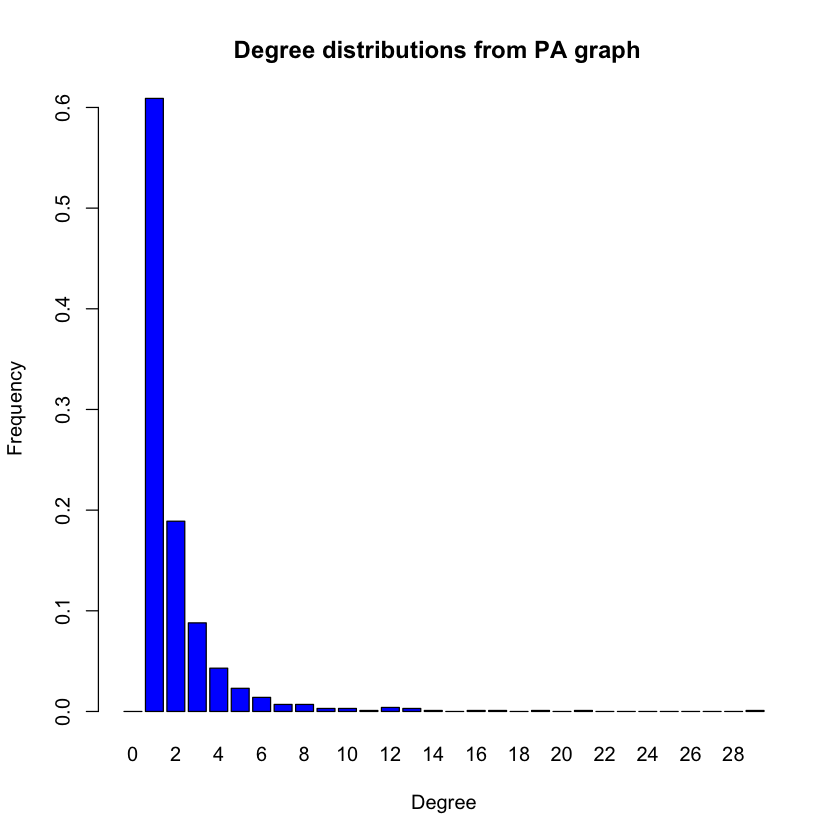

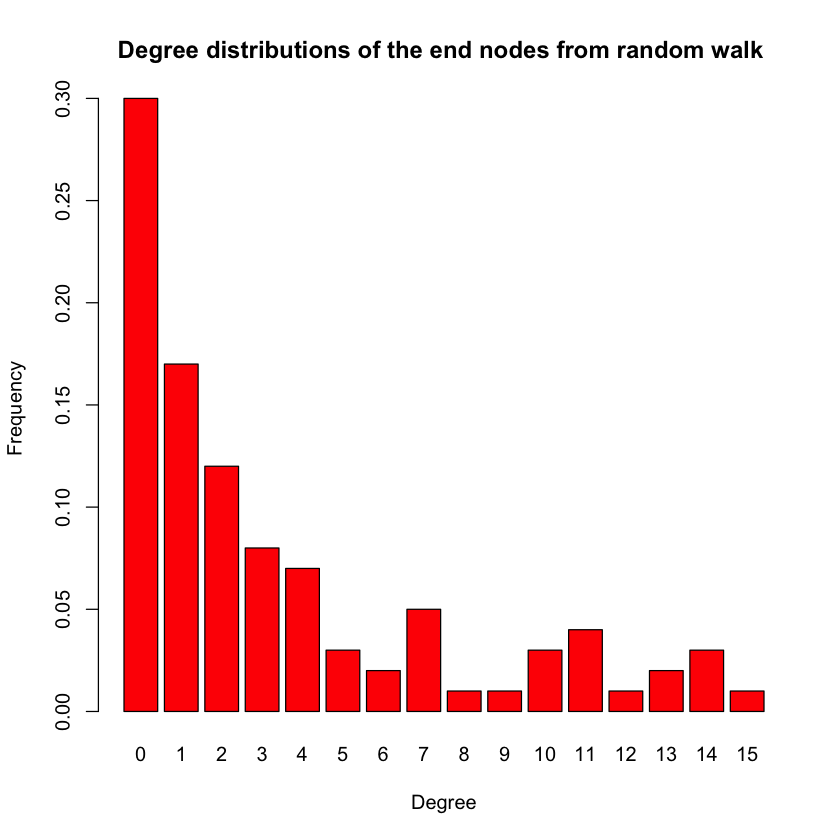

In [522]:
#  degree distribution of graph
d_dist = degree.distribution(pa_g)
xVals = c(0: (length(d_dist) - 1))
barplot(d_dist, names.arg=xVals, xlab="Degree", ylab="Frequency",
            main = paste("Degree distributions from PA graph  " ,sep = " "), col="blue")


#  degree distribution from random walk over random nodes
freq = table(degree_list)/length(degree_list)
xVals = c(0: (length(freq) - 1))
barplot(freq, names.arg=xVals, xlab="Degree", ylab="Frequency",
            main = paste("Degree distributions of the end nodes from random walk " ,sep = " "), col="red")

Comparing the overall distribution to the random walk distribution, they are both fat-tailed with 0 having the largest frequency. The overall distribution has a much larger frequency for this degree while the other ones are slightly higher. There are fluctuations on the right-hand tail of the random walk distribution that don't show up for the overall distribution. 

(d) Repeat 2(b) for preferential attachment networks with 100 and 10000 nodes, and
m = 1. Compare the results and explain qualitatively. Does the diameter of the
network play a role?

100 Nodes:

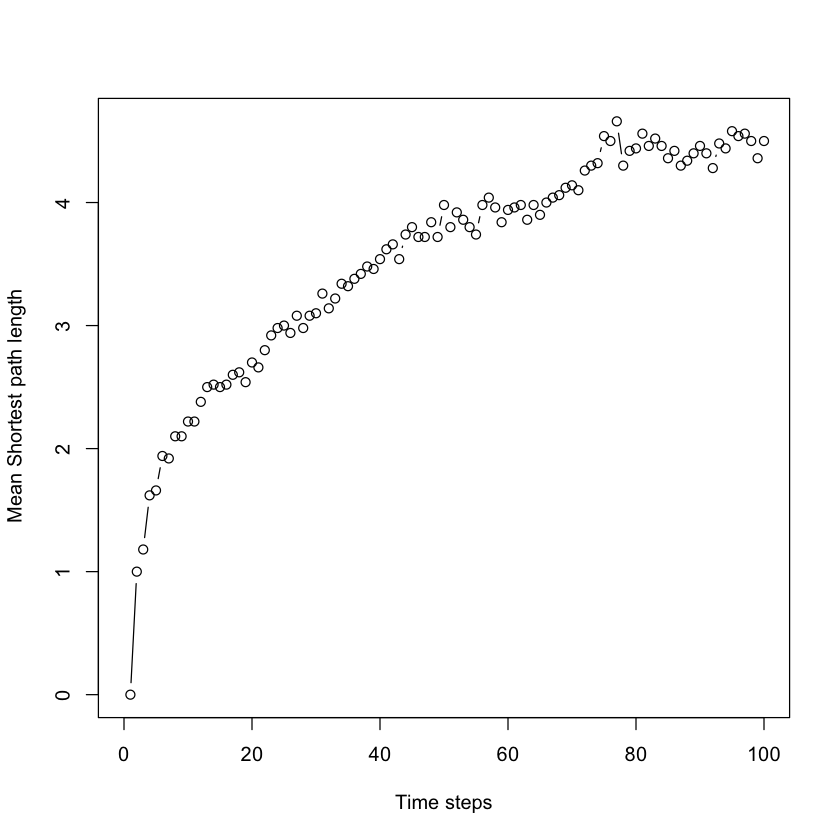

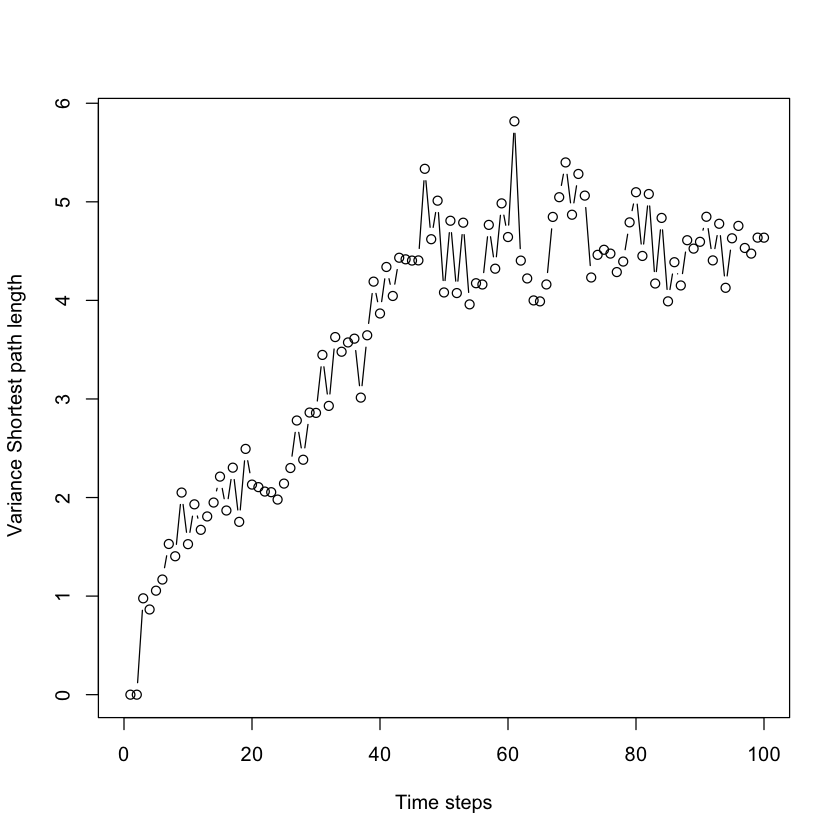

In [579]:
pa_g2 = sample_pa(100,m=1,directed=FALSE)
degree_list = c(1:100)
iters = 100
distances = matrix(NA, nrow=iters, ncol=t)
start_nodes = sample(1:vcount(pa_g2),100)
for(i in 1:iters){
    results = random_walk(pa_g2,t,start_nodes[i])
    vertex_sequences = results[['distances']]
    end_node_degree = results[['degrees']][1]
    distances[i,] = shortest.paths(pa_g2,vertex_sequences,start_nodes[i])
    degree_list[i] = end_node_degree
}

plot(colMeans(distances),type="b", xlab='Time steps', ylab=' Mean Shortest path length', xlim=c(0,100))
plot(colVars(distances),type="b", xlab='Time steps', ylab=' Variance Shortest path length', xlim=c(0,100))

10000 nodes:

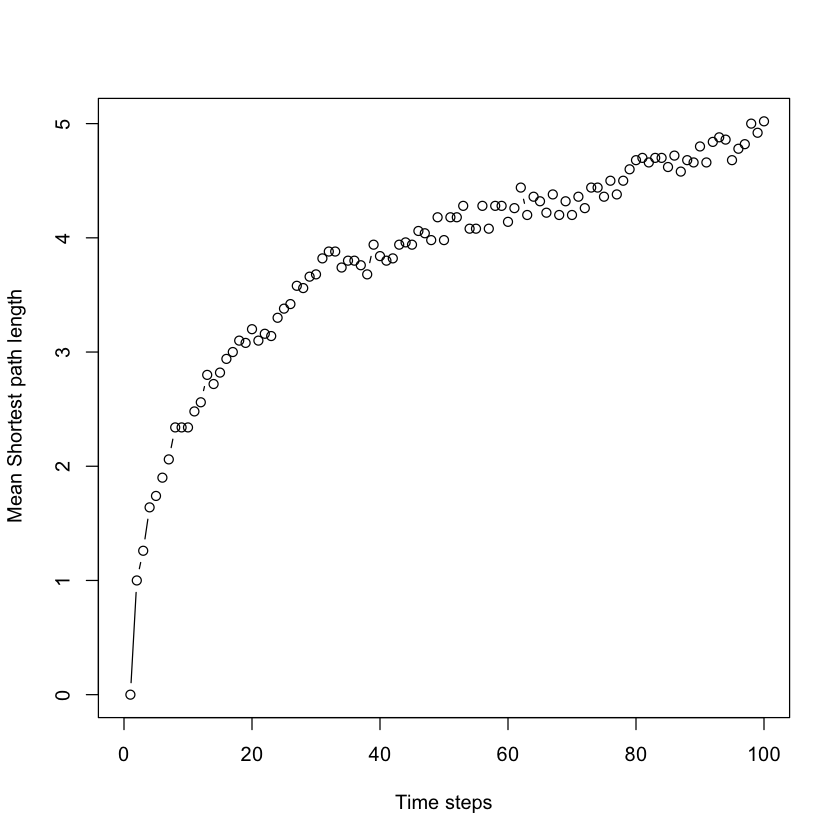

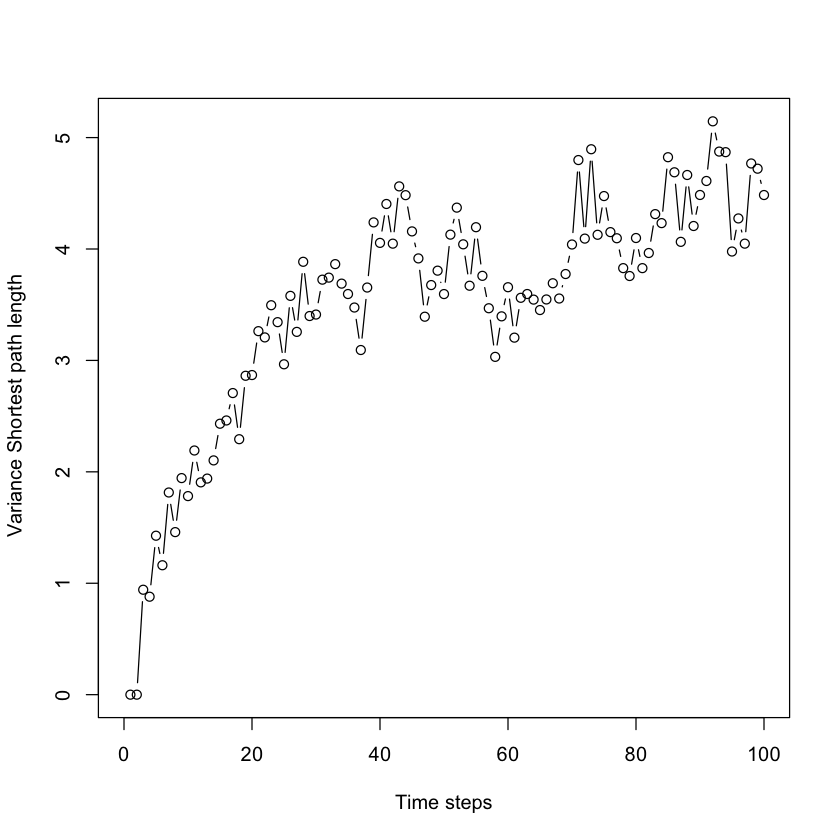

In [534]:
pa_g3 = sample_pa(10000,m=1,directed=FALSE)
degree_list = c(1:100)
iters = 100
distances = matrix(NA, nrow=iters, ncol=t)
start_nodes = sample(1:vcount(pa_g3),100)
for(i in 1:iters){
    results = random_walk(pa_g3,t,start_nodes[i])
    vertex_sequences = results[['distances']]
    end_node_degree = results[['degrees']][1]
    distances[i,] = shortest.paths(pa_g3,vertex_sequences,start_nodes[i])
    degree_list[i] = end_node_degree
}

plot(colMeans(distances),type="b", xlab='Time steps', ylab=' Mean Shortest path length', xlim=c(0,100))
plot(colVars(distances),type="b", xlab='Time steps', ylab=' Variance Shortest path length', xlim=c(0,100))

In [602]:
print(paste("Diameter When n=100:", diameter(pa_g2)))
print(paste("Diameter when n=1000:", diameter(pa_g)))
print(paste("Diameter when n=10000:", diameter(pa_g3)))

[1] 21

[1] "Diameter When n=100: 12"
[1] "Diameter when n=1000: 21"
[1] "Diameter when n=10000: 29"


 For n=1000, the maximum values for both mean shortest path and variance shortest path are around 5.  
for n=100, the maximum values for both mean shortest path and variance shortest path are around 5 and 5.8 respectively. The variance looks to hover around 5.  
For n=10000, the maximum values are again around 5.  

Qualitively, it appears that all three node sizes have the mean and variance shortest paths being around 5 after 100 iterations. The graphs are much less smooth for n=100. The diameters don't look to correspond to the graphs.

3. PageRank

(a) We are going to create a directed random network with 1000 nodes, using the preferential attachment model. Note that in a directed preferential attachment network, the out-degree of every node is m, while the in-degrees follow a power law distribution. One problem of performing random walk in such a network is that, the very first node will have no outbounding edges, and be a “black hole” which a random walker can never “escape” from. To address that, let’s generate another 1000-node random network with preferential attachment model, and merge the two networks by adding the edges of the second graph to the first graph with a shuffling of the indices of the nodes.  
  
Create such a network using m = 4. Measure the probability that the walker visits each node. Is this probability related to the degree of the nodes?

Helper function provided:

In [614]:
random_walk = function (g, num_steps, start_node, transition_matrix, alpha, p_type){
    traversed = rep(0, num_steps)
    if(is.null(transition_matrix))
        transition_matrix = create_transition_matrix(g)
        
    v = start_node
    if(p_type == 'uniform') {
        v_probs = rep(1/vcount(g), vcount(g))
    }
    if(p_type == 'page_rank') {
        v_probs = page_rank(g, directed = TRUE)$vector
    }
    if(p_type == 'median_page_rank') {
        pr = page_rank(g, directed = TRUE)$vector
        ordered = order(pr)
        n_vertices = vcount(g)
        v_probs = rep(0, n_vertices)
        medians = c(ordered[ceil(n_vertices / 2)], ordered[ceil((n_vertices + 1) / 2)])
        v_probs[medians] = 0.5
    }
    else {
        v_probs = rep(1/vcount(g), vcount(g))
    }
    num_visits = 0
    visits_per_node = rep(0, vcount(g))
    v_prob =visits_per_node/num_visits
    for(i in 1:num_steps){
        if(runif(1) < alpha) {
            v = sample(1: vcount(g), 1, prob = v_probs)
        } else {
            PMF = transition_matrix[v, ]
            v = sample(1:vcount(g), 1, prob = PMF)   
        } 
        traversed[i] = v
    }
    return(traversed)
}

In [536]:
network_1 = sample_pa(1000, m=4, directed=TRUE)
network_2 = sample_pa(1000, m=4, directed=TRUE)

In [563]:
permuted_network_2 = permute(network_2, sample(gorder(network_2)))
network_2_edges = as_edgelist(permuted_network_2)
merged = add_edges(network_1, c(t(network_2_edges)))

[1] "Pearson Correlation between Degree of nodes and visit prob::  0.854417032217429"


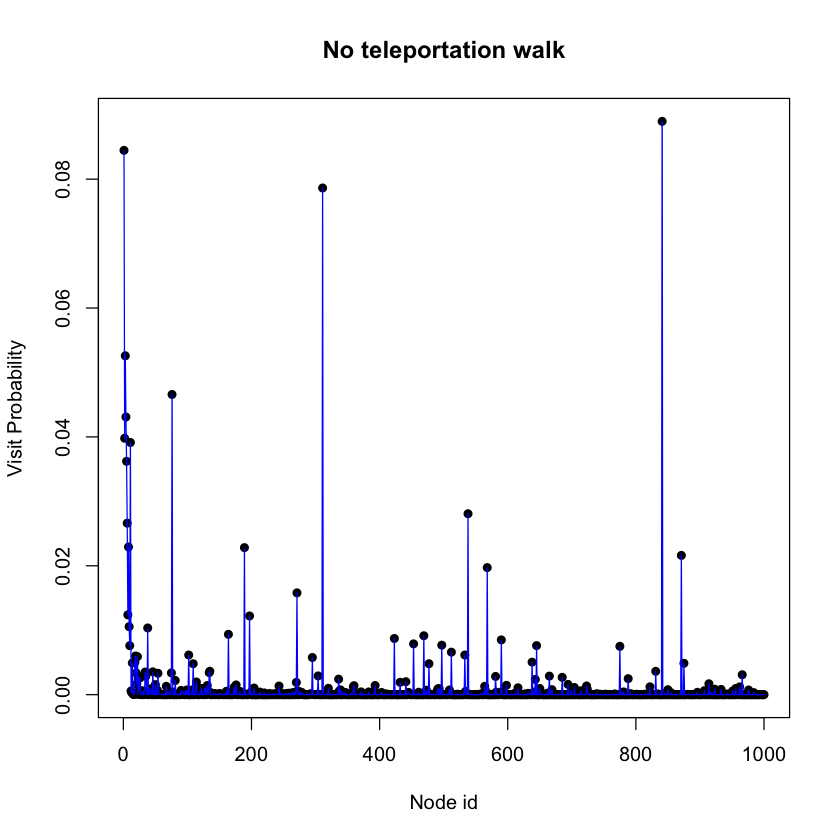

In [564]:
iters = 100
freq = rep(0, 1000)
n_steps = vcount(merged)
SSteps = ceiling(log(vcount(merged)))

for(i in (1:iters)) {
    walk = random_walk(merged, n_steps, sample(vcount(merged), 1), NULL, 0.0, '')
    
    for (j in (1: n_steps)) {
        freq[walk[j]] = freq[walk[j]] + 1
    }
}

freq = freq / ((n_steps - SSteps) * iters)

plot((1:1000), freq, pch=16, xlab="Node id", ylab="Visit Probability", main="No teleportation walk")
lines(freq, col='blue')

print(paste("Pearson Correlation between Degree of nodes and visit prob:: ", cor(degree(merged), freq)))

[1] "Intercept and slope:: "

Call:
lm(formula = freq ~ degree(merged))

Coefficients:
   (Intercept)  degree(merged)  
    -0.0018703       0.0001803  



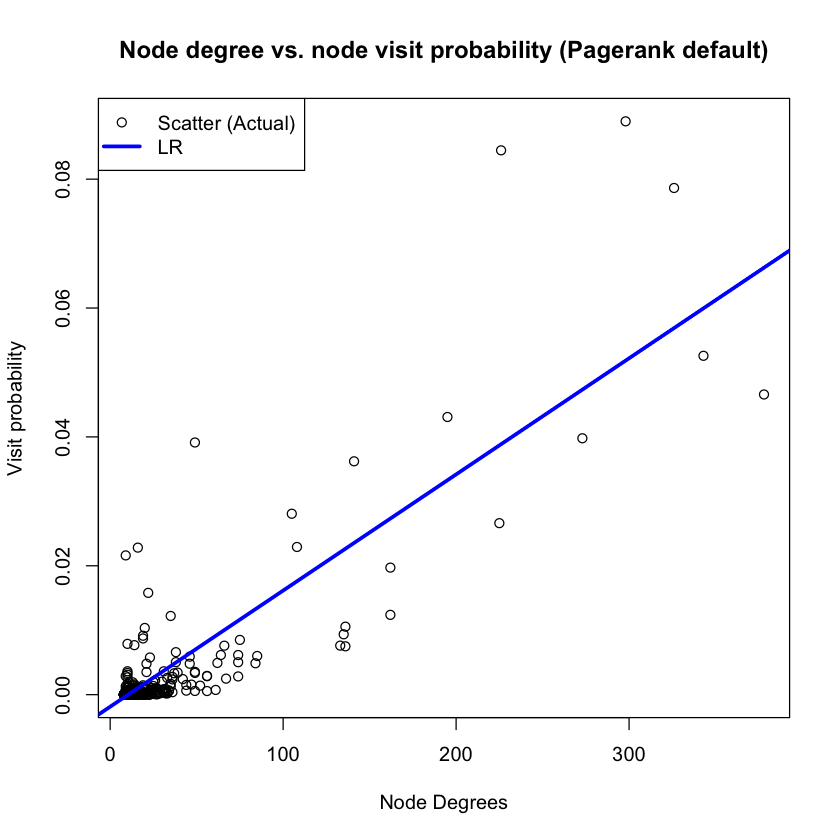

In [566]:
plot(degree(merged), freq , xlab='Node Degrees', ylab='Visit probability',main="Node degree vs. node visit probability (Pagerank default)")

abline(lm(freq ~ degree(merged)), col="blue",lwd=3,lty=1)
legend('topleft', legend = c("Scatter (Actual)", "LR"),
       lty = c(NA, 1), lwd = c(1,3), pch=c(1,NA),
       col = c('black','blue'))

print("Intercept and slope:: ")
print(lm(freq ~ degree(merged)))

(b) In all previous questions, we didn’t have any teleportation. Now, we use a teleportation probability of α = 0.15. By performing random walks on the network created
in 3(a), measure the probability that the walker visits each node. Is this probability
related to the degree of the node?

[1] "Pearson Correlation between Degree of nodes and visit prob:  0.891511955428222"


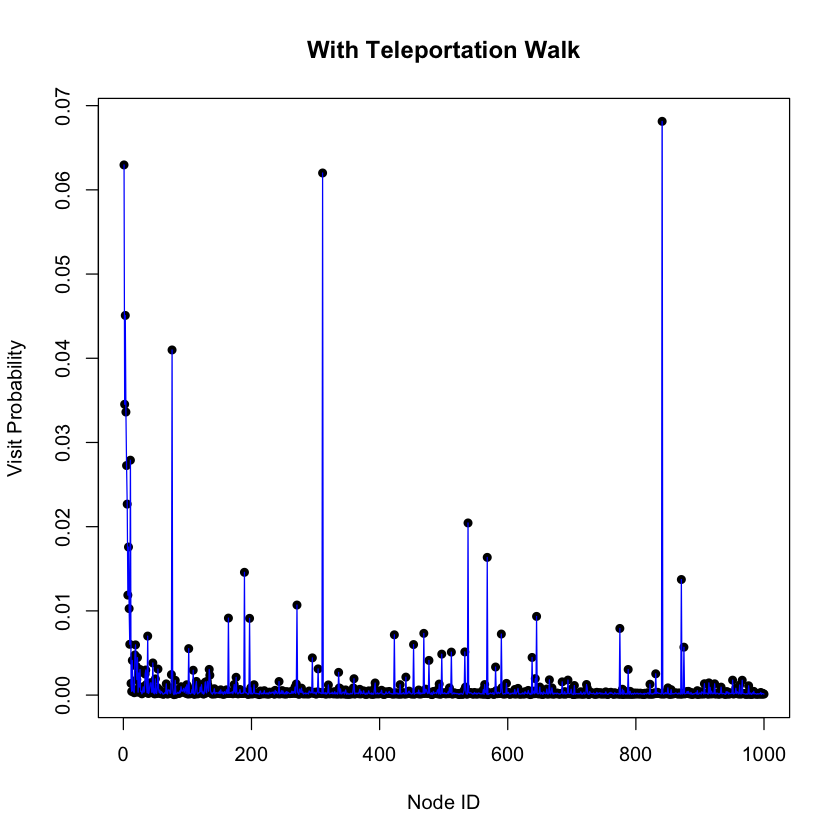

In [571]:
iters = 100
freq = rep(0, 1000)
n_steps = vcount(merged)
SSteps = ceiling(log(vcount(merged)))

for(i in (1:iters)) {
    walk = random_walk(merged, n_steps, sample(vcount(merged), 1), NULL, 0.15, '')
    
    for (j in (1: n_steps)) {
        freq[walk[j]] = freq[walk[j]] + 1
    }
}

freq = freq / ((n_steps - SSteps) * iters)

plot((1:1000), freq, pch=16, xlab="Node ID", ylab="Visit Probability", main="With Teleportation Walk")
lines(freq, col='blue')

print(paste("Pearson Correlation between Degree of nodes and visit prob: ", cor(degree(merged), freq)))

[1] "Intercept and slope:: "

Call:
lm(formula = freq ~ degree(merged))

Coefficients:
   (Intercept)  degree(merged)  
    -0.0013278       0.0001463  



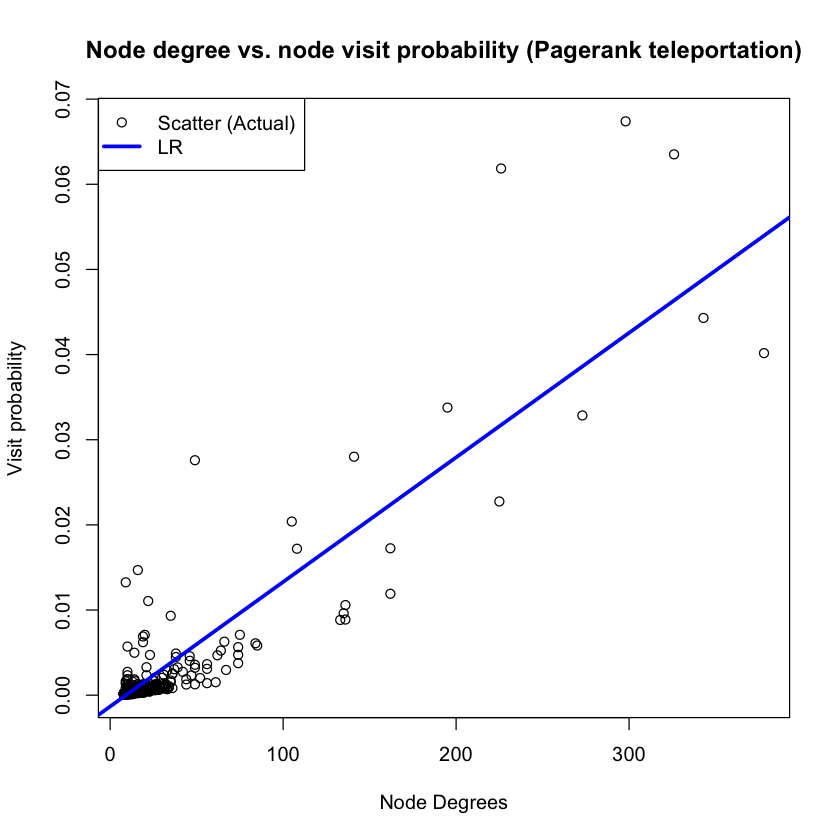

In [569]:
plot(degree(merged), freq , xlab='Node Degrees', ylab='Visit probability',main="Node degree vs. node visit probability (Pagerank teleportation)")

abline(lm(freq ~ degree(merged)), col="blue",lwd=3,lty=1)
legend('topleft', legend = c("Scatter (Actual)", "LR"),
       lty = c(NA, 1), lwd = c(1,3), pch=c(1,NA),
       col = c('black','blue'))

print("Intercept and slope:: ")
print(lm(freq ~ degree(merged)))

4. Personalized PageRank

(a) Suppose you have your own notion of importance. Your interest in a node is proportional to the node’s PageRank, because you totally rely upon Google to decide which
website to visit (assume that these nodes represent websites). Again, use random
walk on network generated in question 3 to simulate this personalized PageRank.
Here the teleportation probability to each node is proportional to its PageRank (as
opposed to the regular PageRank, where at teleportation, the chance of visiting all
nodes are the same and equal to $\frac {1}{N}$ ). Again, let the teleportation probability be
equal to α = 0.15. Compare the results with 3(a).

[1] "Pearson Correlation between Degree of nodes and visit prob:  0.894858286327442"


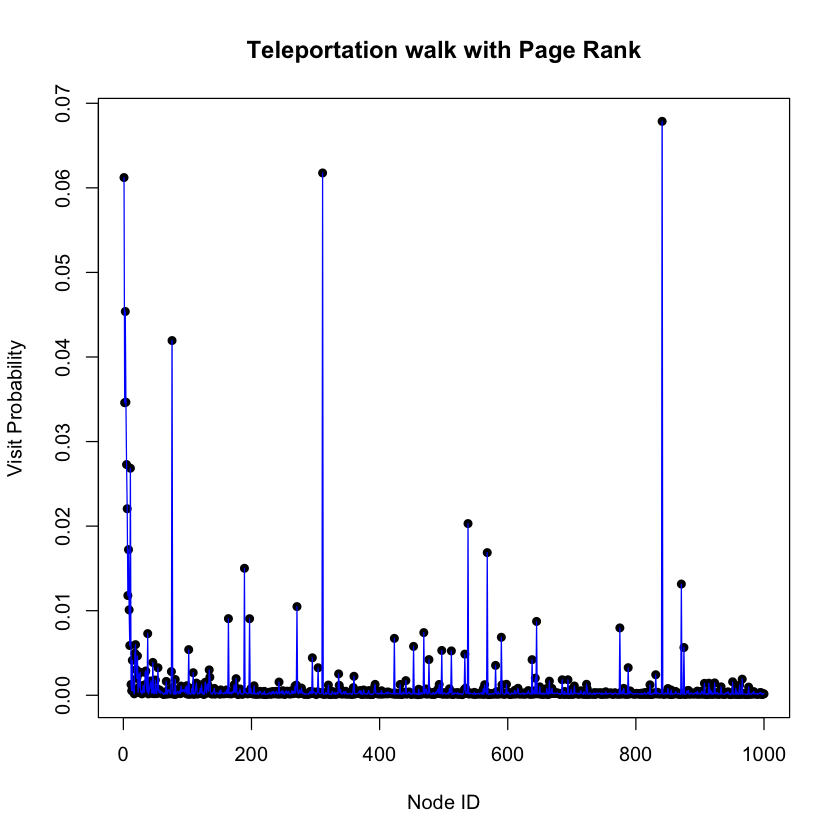

In [625]:
iters = 100
freq = rep(0, 1000)
n_steps = vcount(merged)
SSteps = ceiling(log(vcount(merged)))

for(i in (1:iters)) {
    walk = random_walk(merged, n_steps, sample(vcount(merged), 1), NULL, 0.15, 'page_rank')
    
    for (j in (1: n_steps)) {
        freq[walk[j]] = freq[walk[j]] + 1
    }
}

freq = freq / ((n_steps - SSteps) * iters)

plot((1:1000), freq, pch=16, xlab="Node ID", ylab="Visit Probability", main="Teleportation walk with Page Rank")
lines(freq, col='blue')

print(paste("Pearson Correlation between Degree of nodes and visit prob: ", cor(degree(merged), freq)))

[1] "Intercept and slope:: "

Call:
lm(formula = freq ~ degree(merged))

Coefficients:
   (Intercept)  degree(merged)  
    -0.0013342       0.0001467  



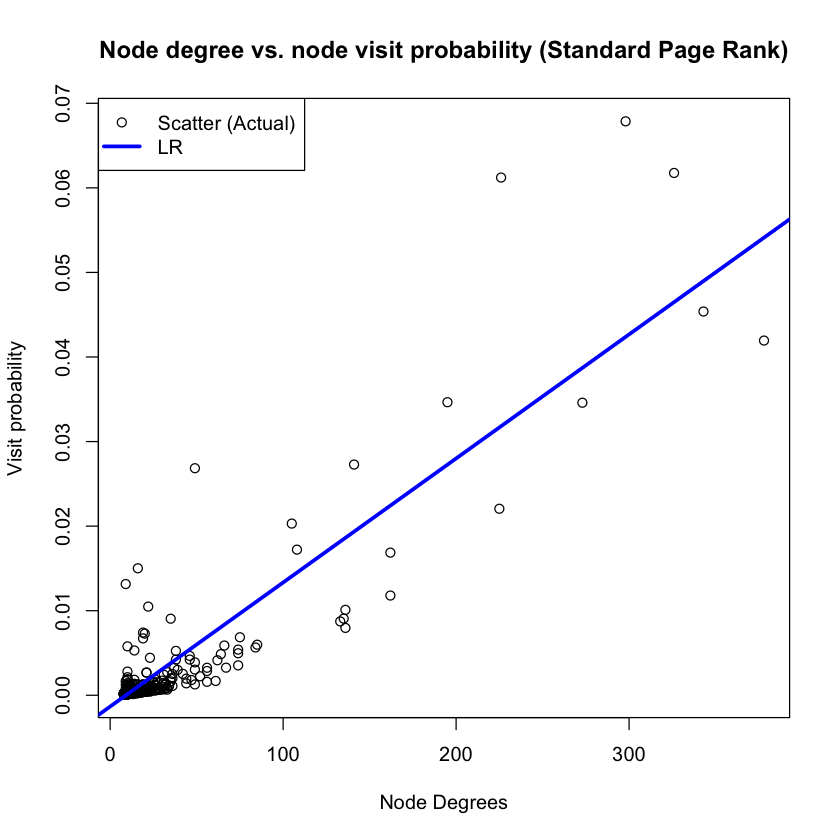

In [626]:
plot(degree(merged), freq , xlab='Node Degrees', ylab='Visit probability',main="Node degree vs. node visit probability (Standard Page Rank)")

abline(lm(freq ~ degree(merged)), col="blue",lwd=3,lty=1)
legend('topleft', legend = c("Scatter (Actual)", "LR"),
       lty = c(NA, 1), lwd = c(1,3), pch=c(1,NA),
       col = c('black','blue'))

print("Intercept and slope:: ")
print(lm(freq ~ degree(merged)))

3a: Max visit probability: ~0.09, correlation: ~0.85, slope of regression: ~0.00018  
Here: Max visit probability: ~0.065, correlation: ~0.89, slope of regression: ~0.00015     
  
Qualitiatively, the max visit probability and the slope of the regression line are greater for 3a while the correlation is greater here.

(b) Find two nodes in the network with median PageRanks. Repeat part 4(a) if teleportations land only on those two nodes (with probabilities 1/2, 1/2). How are the
PageRank values affected?

[1] "Pearson Correlation between Degree of nodes and visit prob:  0.893688921631156"


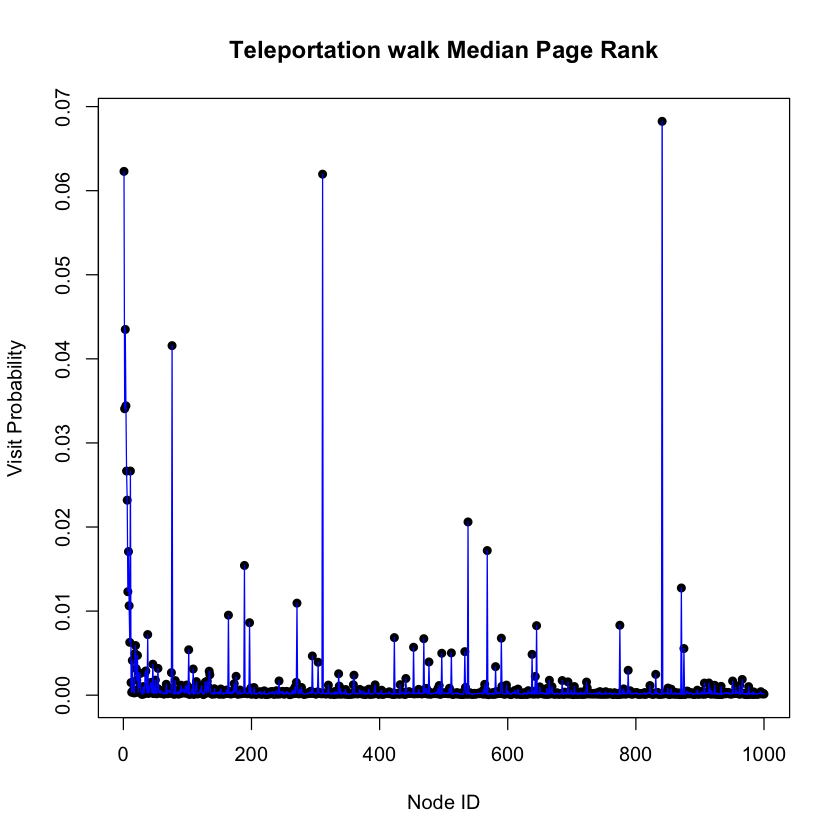

In [615]:
iters = 100
freq = rep(0, 1000)
n_steps = vcount(merged)
SSteps = ceiling(log(vcount(merged)))

for(i in (1:iters)) {
    walk = random_walk(merged, n_steps, sample(vcount(merged), 1), NULL, 0.15, 'page_rank_median')
    
    for (j in (1: n_steps)) {
        freq[walk[j]] = freq[walk[j]] + 1
    }
}

freq = freq / ((n_steps - SSteps) * iters)

plot((1:1000), freq, pch=16, xlab="Node ID", ylab="Visit Probability", main="Teleportation walk Median Page Rank")
lines(freq, col='blue')

print(paste("Pearson Correlation between Degree of nodes and visit prob: ", cor(degree(merged), freq)))

[1] "Intercept and slope:: "

Call:
lm(formula = freq ~ degree(merged))

Coefficients:
   (Intercept)  degree(merged)  
    -0.0013264       0.0001462  



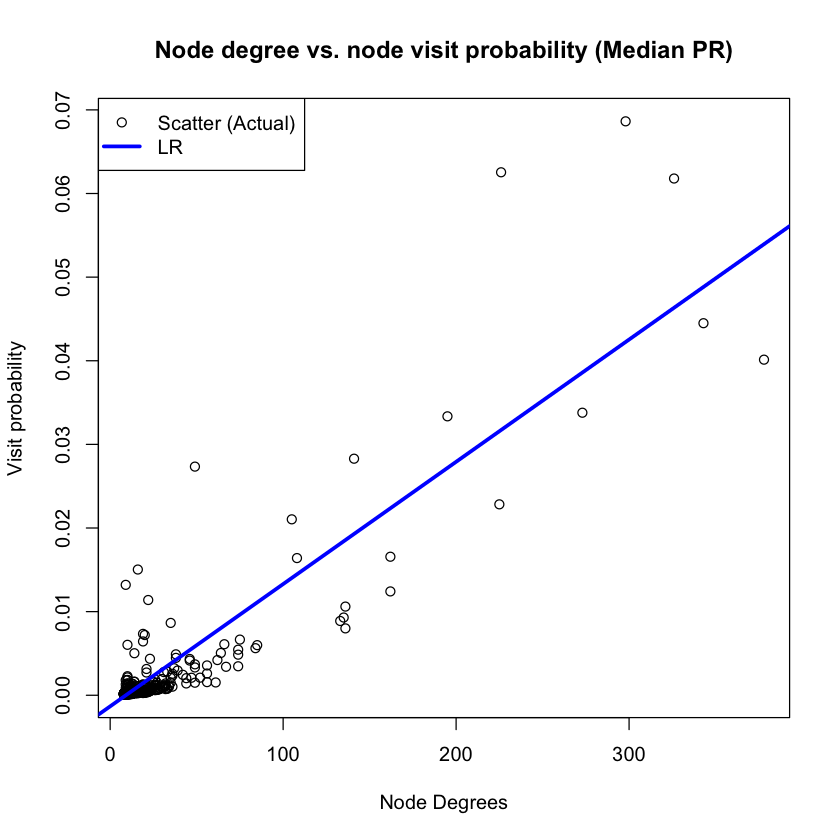

In [576]:
plot(degree(merged), freq , xlab='Node Degrees', ylab='Visit probability',main="Node degree vs. node visit probability (Median PR)")

abline(lm(freq ~ degree(merged)), col="blue",lwd=3,lty=1)
legend('topleft', legend = c("Scatter (Actual)", "LR"),
       lty = c(NA, 1), lwd = c(1,3), pch=c(1,NA),
       col = c('black','blue'))

print("Intercept and slope:: ")
print(lm(freq ~ degree(merged)))

From the helper code, since v_probs is set to the page_rank output vector for normal page_rank, the assumption made is that to compare the PageRank differences between 3a and here, we can compare the visit probabilities. The regression slope is slightly lower here at 0.0001462 compared to 3a where it is 0.0001467. The maximum probabilities for the first graph look to be around the same qualitatively.

(c) More or less, 4(b) is what happens in the real world, in that a user browsing the web
only teleports to a set of trusted web pages. However, this is against the assumption
of normal PageRank, where we assume that people’s interest in all nodes are the
same. Can you take into account the effect of this self-reinforcement and adjust the
PageRank equation?

According to the description of pagerank here: http://infolab.stanford.edu/~backrub/google.html,  
there is a variation that can be done to the pagerank equation to only have the damping factor d be applied to a subset of pages. This damping factor is the probability that a web surfer will go to a random page instead of clicking links on the current page. This makes personalization possible instead of assuming that people's interest in all nodes are the same. There's a parameter named "personalized" for the page_rank function that handles these calculations. The median probabilities both set to 0.5 can be passed into this personalized parameter and then vprobs could be taken from the pagerank vector like for regular pagerank.

In [619]:
random_walk = function (g, num_steps, start_node, transition_matrix, alpha){
    traversed = rep(0, num_steps)
    if(is.null(transition_matrix))
        transition_matrix = create_transition_matrix(g)
        
    v = start_node
    
    # first do regular page_rank to get the ordered list of nodes to calculate the median
    pr = page_rank(g, directed = TRUE)$vector
    ordered = order(pr)
    n_vertices = vcount(g)
    personalized_probs = rep(0, n_vertices)
    medians = c(ordered[ceil(n_vertices / 2)], ordered[ceil((n_vertices + 1) / 2)])
    
    # Set these median node probabilities to 0.5 and pass in as personalized parameter
    personalized_probs[medians] = 0.5
    personalized_pr = page_rank(g, directed=TRUE, personalized=personalized_probs)
    v_probs = personalized_pr$vector

    for(i in 1:num_steps){
        if(runif(1) < alpha) {
            v = sample(1: vcount(g), 1, prob = v_probs)
        } else {
            PMF = transition_matrix[v, ]
            v = sample(1:vcount(g), 1, prob = PMF)
        } 
        traversed[i] = v
    }
    return(traversed)
}

[1] "Pearson Correlation between Degree of nodes and visit prob:  0.870283330467242"


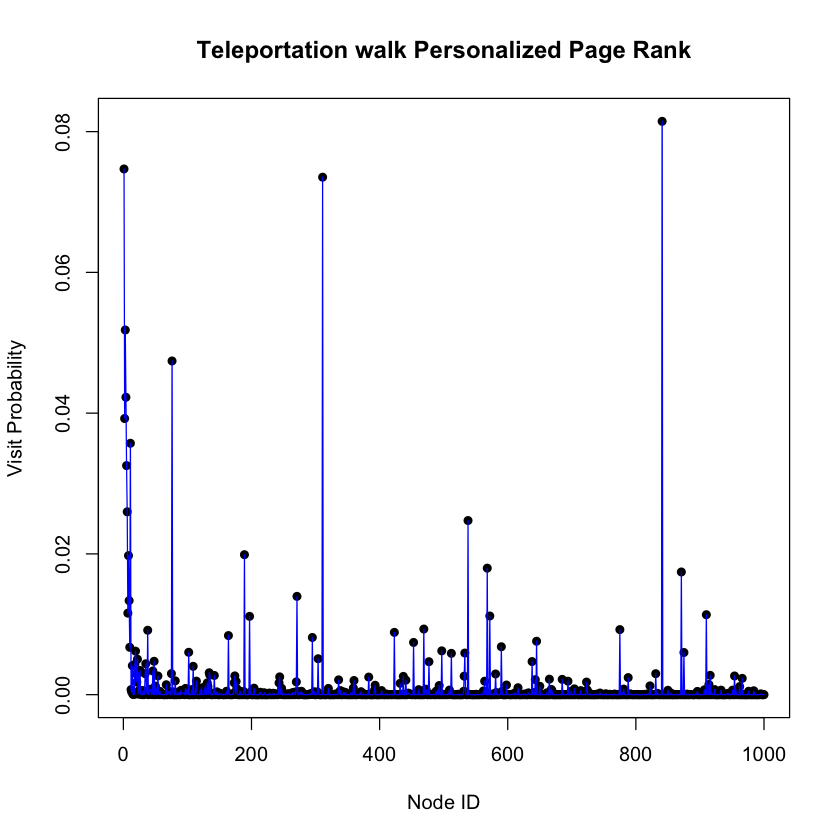

In [620]:
iters = 100
freq = rep(0, 1000)
n_steps = vcount(merged)
SSteps = ceiling(log(vcount(merged)))

for(i in (1:iters)) {
    walk = random_walk(merged, n_steps, sample(vcount(merged), 1), NULL, 0.15)
    
    for (j in (1: n_steps)) {
        freq[walk[j]] = freq[walk[j]] + 1
    }
}

freq = freq / ((n_steps - SSteps) * iters)

plot((1:1000), freq, pch=16, xlab="Node ID", ylab="Visit Probability", main="Teleportation walk Personalized Page Rank")
lines(freq, col='blue')

print(paste("Pearson Correlation between Degree of nodes and visit prob: ", cor(degree(merged), freq)))

[1] "Intercept and slope:: "

Call:
lm(formula = freq ~ degree(merged))

Coefficients:
   (Intercept)  degree(merged)  
    -0.0017283       0.0001714  



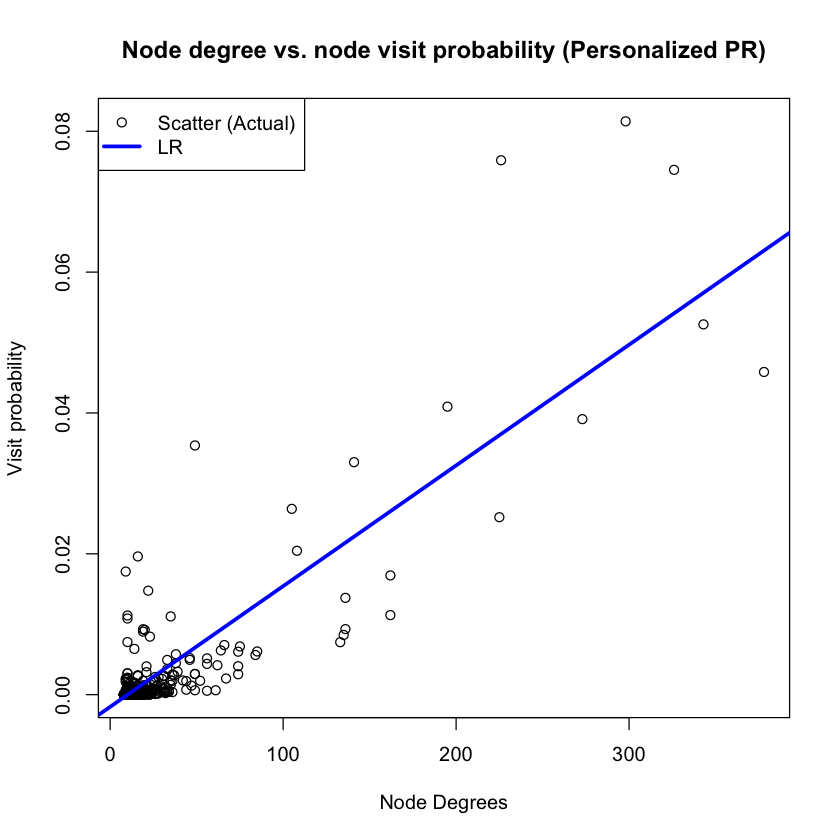

In [622]:
plot(degree(merged), freq , xlab='Node Degrees', ylab='Visit probability',main="Node degree vs. node visit probability (Personalized PR)")

abline(lm(freq ~ degree(merged)), col="blue",lwd=3,lty=1)
legend('topleft', legend = c("Scatter (Actual)", "LR"),
       lty = c(NA, 1), lwd = c(1,3), pch=c(1,NA),
       col = c('black','blue'))

print("Intercept and slope:: ")
print(lm(freq ~ degree(merged)))